# Cellular Behavior Analysis
This notebook uses autoencoders to explore dynamic cellular behaviors

In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.5.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [33]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import io
import json
import os
import re
import tarfile
import tempfile

import numpy as np
import math

from scipy.spatial.distance import cdist

from skimage.measure import regionprops
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import resize


def clean_up_annotations(y, uid=None, data_format='channels_last'):
    """Relabels every frame in the label matrix.
    Args:
        y (np.array): annotations to relabel sequentially.
        uid (int, optional): starting ID to begin labeling cells.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        np.array: Cleaned up annotations.
    """
    y = y.astype('int32')
    time_axis = 1 if data_format == 'channels_first' else 0
    num_frames = y.shape[time_axis]

    all_uniques = []
    for f in range(num_frames):
        cells = np.unique(y[:, f] if data_format == 'channels_first' else y[f])
        cells = np.delete(cells, np.where(cells == 0))
        all_uniques.append(cells)

    # The annotations need to be unique across all frames
    uid = sum(len(x) for x in all_uniques) + 1 if uid is None else uid
    for frame, unique_cells in zip(range(num_frames), all_uniques):
        y_frame = y[:, frame] if data_format == 'channels_first' else y[frame]
        y_frame_new = np.zeros(y_frame.shape)
        for cell_label in unique_cells:
            y_frame_new[y_frame == cell_label] = uid
            uid += 1
        if data_format == 'channels_first':
            y[:, frame] = y_frame_new
        else:
            y[frame] = y_frame_new
    return y


def count_pairs(y, same_probability=0.5, data_format='channels_last'):
    """Compute number of training samples needed to observe all cell pairs.
    Args:
        y (np.array): 5D tensor of cell labels.
        same_probability (float): liklihood that 2 cells are the same.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        int: the total pairs needed to sample to see all possible pairings.
    """
    total_pairs = 0
    zaxis = 2 if data_format == 'channels_first' else 1
    for b in range(y.shape[0]):
        # count the number of cells in each image of the batch
        cells_per_image = []
        for f in range(y.shape[zaxis]):
            if data_format == 'channels_first':
                num_cells = len(np.unique(y[b, :, f, :, :]))
            else:
                num_cells = len(np.unique(y[b, f, :, :, :]))
            cells_per_image.append(num_cells)

        # Since there are many more possible non-self pairings than there
        # are self pairings, we want to estimate the number of possible
        # non-self pairings and then multiply that number by two, since the
        # odds of getting a non-self pairing are 50%, to find out how many
        # pairs we would need to sample to (statistically speaking) observe
        # all possible cell-frame pairs. We're going to assume that the
        # average cell is present in every frame. This will lead to an
        # underestimate of the number of possible non-self pairings, but it
        # is unclear how significant the underestimate is.
        average_cells_per_frame = sum(cells_per_image) // y.shape[zaxis]
        non_self_cellframes = (average_cells_per_frame - 1) * y.shape[zaxis]
        non_self_pairings = non_self_cellframes * max(cells_per_image)

        # Multiply cell pairings by 2 since the
        # odds of getting a non-self pairing are 50%
        cell_pairings = non_self_pairings // same_probability
        # Add this batch cell-pairings to the total count
        total_pairs += cell_pairings
    return total_pairs


def load_trks(filename):
    """Load a trk/trks file.
    Args:
        filename (str): full path to the file including .trk/.trks.
    Returns:
        dict: A dictionary with raw, tracked, and lineage data.
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = io.BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = io.BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

        # trks.extractfile opens a file in bytes mode, json can't use bytes.
        _, file_extension = os.path.splitext(filename)

        if file_extension == '.trks':
            trk_data = trks.getmember('lineages.json')
            lineages = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            for i, tracks in enumerate(lineages):
                lineages[i] = {int(k): v for k, v in tracks.items()}

        elif file_extension == '.trk':
            trk_data = trks.getmember('lineage.json')
            lineage = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            lineages = []
            lineages.append({int(k): v for k, v in lineage.items()})

    return {'lineages': lineages, 'X': raw, 'y': tracked}


def trk_folder_to_trks(dirname, trks_filename):
    """Compiles a directory of trk files into one trks_file.
    Args:
        dirname (str): full path to the directory containing multiple trk files.
        trks_filename (str): desired filename (the name should end in .trks).
    """
    lineages = []
    raw = []
    tracked = []

    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    file_list = os.listdir(dirname)
    file_list_sorted = sorted(file_list, key=alphanum_key)

    for filename in file_list_sorted:
        trk = load_trks(os.path.join(dirname, filename))
        lineages.append(trk['lineages'][0])  # this is loading a single track
        raw.append(trk['X'])
        tracked.append(trk['y'])

    file_path = os.path.join(os.path.dirname(dirname), trks_filename)

    save_trks(file_path, lineages, raw, tracked)


def save_trks(filename, lineages, raw, tracked):
    """Saves raw, tracked, and lineage data into one trks_file.
    Args:
        filename (str): full path to the final trk files.
        lineages (dict): a list of dictionaries saved as a json.
        raw (np.array): raw images data.
        tracked (np.array): annotated image data.
    Raises:
        ValueError: filename does not end in ".trks".
    """
    if not str(filename).lower().endswith('.trks'):
        raise ValueError('filename must end with `.trks`. Found %s' % filename)

    with tarfile.open(filename, 'w:gz') as trks:
        with tempfile.NamedTemporaryFile('w', delete=False) as lineages_file:
            json.dump(lineages, lineages_file, indent=4)
            lineages_file.flush()
            lineages_file.close()
            trks.add(lineages_file.name, 'lineages.json')
            os.remove(lineages_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            raw_file.close()
            trks.add(raw_file.name, 'raw.npy')
            os.remove(raw_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as tracked_file:
            np.save(tracked_file, tracked)
            tracked_file.flush()
            tracked_file.close()
            trks.add(tracked_file.name, 'tracked.npy')
            os.remove(tracked_file.name)


def trks_stats(filename):
    """For a given trks_file, find the Number of cell tracks,
       the Number of frames per track, and the Number of divisions.
    Args:
        filename (str): full path to a trks file.
    Raises:
        ValueError: filename is not a .trk or .trks file.
    """
    ext = os.path.splitext(filename)[-1].lower()
    if ext not in {'.trks', '.trk'}:
        raise ValueError('`trks_stats` expects a .trk or .trks but found a ' +
                         str(ext))

    training_data = load_trks(filename)
    X = training_data['X']
    y = training_data['y']
    daughters = [{cell: fields['daughters']
                  for cell, fields in tracks.items()}
                 for tracks in training_data['lineages']]

    print('Dataset Statistics: ')
    print('Image data shape: ', X.shape)
    print('Number of lineages (should equal batch size): ',
          len(training_data['lineages']))

    # Calculate cell density
    frame_area = X.shape[2] * X.shape[3]

    avg_cells_in_frame = []
    for batch in range(y.shape[0]):
        num_cells_in_frame = []
        for frame in y[batch]:
            cells_in_frame = len(np.unique(frame)) - 1  # unique returns 0 (BKGD)
            num_cells_in_frame.append(cells_in_frame)
        avg_cells_in_frame.append(np.average(num_cells_in_frame))
    avg_cells_per_sq_pixel = np.average(avg_cells_in_frame) / frame_area

    # Calculate division information
    total_tracks = 0
    total_divisions = 0
    avg_frame_counts_in_batches = []
    for batch, daughter_batch in enumerate(daughters):
        num_tracks_in_batch = len(daughter_batch)
        num_div_in_batch = len([c for c in daughter_batch if daughter_batch[c]])
        total_tracks = total_tracks + num_tracks_in_batch
        total_divisions = total_divisions + num_div_in_batch
        frame_counts = []
        for cell_id in daughter_batch.keys():
            frame_count = 0
            for frame in y[batch]:
                cells_in_frame = np.unique(frame)
                if cell_id in cells_in_frame:
                    frame_count += 1
            frame_counts.append(frame_count)
        avg_frame_counts_in_batches.append(np.average(frame_counts))
    avg_num_frames_per_track = np.average(avg_frame_counts_in_batches)

    print('Total number of unique tracks (cells)      - ', total_tracks)
    print('Total number of divisions                  - ', total_divisions)
    print('Average cell density (cells/100 sq pixels) - ', avg_cells_per_sq_pixel * 100)
    print('Average number of frames per track         - ', int(avg_num_frames_per_track))


def get_max_cells(y):
    """Helper function for finding the maximum number of cells in a frame of a movie, across
    all frames of the movie. Can be used for batches/tracks interchangeably with frames/cells.
    Args:
        y (np.array): Annotated image data
    Returns:
        int: The maximum number of cells in any frame
    """
    max_cells = 0
    for frame in range(y.shape[0]):
        cells = np.unique(y[frame])
        n_cells = cells[cells != 0].shape[0]
        if n_cells > max_cells:
            max_cells = n_cells
    return max_cells


def normalize_adj_matrix(adj, epsilon=1e-5):
    """Normalize the adjacency matrix
    Args:
        adj (np.array): Adjacency matrix
        epsilon (float): Used to create the degree matrix
    Returns:
        np.array: Normalized adjacency matrix
    Raises:
        ValueError: If ``adj`` has a rank that is not 3 or 4.
    """
    input_rank = len(adj.shape)
    if input_rank not in {3, 4}:
        raise ValueError('Only 3 & 4 dim adjacency matrices are supported')

    if input_rank == 3:
        # temporarily include a batch dimension for consistent processing
        adj = np.expand_dims(adj, axis=0)

    normalized_adj = np.zeros(adj.shape, dtype='float32')

    for t in range(adj.shape[1]):
        adj_frame = adj[:, t]
        # create degree matrix
        degrees = np.sum(adj_frame, axis=1)
        for batch, degree in enumerate(degrees):
            degree = (degree + epsilon) ** -0.5
            degree_matrix = np.diagflat(degree)

            normalized = np.matmul(degree_matrix, adj_frame[batch])
            normalized = np.matmul(normalized, degree_matrix)
            normalized_adj[batch, t] = normalized

    if input_rank == 3:
        # remove batch axis
        normalized_adj = normalized_adj[0]

    return normalized_adj


def relabel_sequential_lineage(y, lineage):
    """Ensure the lineage information is sequentially labeled.
    Args:
        y (np.array): Annotated z-stack of image labels.
        lineage (dict): Lineage data for y.
    Returns:
        tuple(np.array, dict): The relabeled array and corrected lineage.
    """
    y_relabel, fw, _ = relabel_sequential(y)

    new_lineage = {}

    cell_ids = np.unique(y)
    cell_ids = cell_ids[cell_ids != 0]
    for cell_id in cell_ids:
        new_cell_id = fw[cell_id]

        new_lineage[new_cell_id] = {}

        # Fix label
        # TODO: label == track ID?
        new_lineage[new_cell_id]['label'] = new_cell_id

        # Fix parent
        parent = lineage[cell_id]['parent']
        new_parent = fw[parent] if parent is not None else parent
        new_lineage[new_cell_id]['parent'] = new_parent

        # Fix daughters
        daughters = lineage[cell_id]['daughters']
        new_lineage[new_cell_id]['daughters'] = [fw[d] for d in daughters]

        # Fix frames
        y_true = np.sum(y == cell_id, axis=(1, 2))
        y_index = np.where(y_true > 0)[0]
        new_lineage[new_cell_id]['frames'] = list(y_index)

    return y_relabel, new_lineage


def is_valid_lineage(lineage):
    """Check if a cell lineage of a single movie is valid.
    Daughter cells must exist in the frame after the parent's final frame.
    Args:
        lineage (dict): The cell lineages for a single movie.
    Returns:
        bool: Whether or not the lineage is valid.
    """
    for cell_lineage in lineage.values():
        # Get last frame of parent
        last_parent_frame = cell_lineage['frames'][-1]

        for daughter in cell_lineage['daughters']:
            # get first frame of daughter
            first_daughter_frame = lineage[daughter]['frames'][0]

            # Check that daughter's start frame is one larger than parent end frame
            if first_daughter_frame - last_parent_frame != 1:
                return False

    return True  # all cell lineages are valid!

def get_appearance_dimensions(X_arr, y_arr):
    """Get the dimensions of the appearance images.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        tuple: A tuple of dimensions of shape (2)."""
    app_rows = 0
    app_cols = 0
    
    n_batches = X_arr.shape[0]
    n_frames = X_arr.shape[1]
    
    for batch in range(n_batches):
        for frame in range(n_frames):
            y = y_arr[batch, frame]
            props = regionprops(y[..., 0], cache=False)
            for prop in props:
                # Get appearance dimensions
                minr, minc, maxr, maxc = prop.bbox
                row = maxr - minr
                col = maxc - minc
                if row > app_rows:
                    app_rows = row
                if col > app_cols:
                    app_cols = col

    return app_rows, app_cols


def get_image_features(X, y, app_rows, app_cols):
    """Return features for every object in the array.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        dict: A dictionary of feature names to np.arrays of shape
            (n, c) or (n, x, y, c) where n is the number of objects.
    """

    # each feature will be ordered based on the label.
    # labels are also stored and can be fetched by index.
    num_labels = len(np.unique(y)) - 1
    labels = np.zeros((num_labels,), dtype='int32')
    centroids = np.zeros((num_labels, 2), dtype='float32')
    morphologies = np.zeros((num_labels, 3), dtype='float32')
    
    app_rows = int(app_rows)
    app_cols = int(app_cols)

    appearances = np.zeros((num_labels, app_rows, app_cols, X.shape[-1]),
                            dtype='float32')

    # iterate over all objects in y
    props = regionprops(y[..., 0], cache=False)
    for i, prop in enumerate(props):
        # Get label
        labels[i] = prop.label

        # Get centroid
        centroid = np.array(prop.centroid)
        centroids[i] = centroid

        # Get morphology
        morphology = np.array([
            prop.area,
            prop.perimeter,
            prop.eccentricity
        ])
        morphologies[i] = morphology

        # Get appearance
        minr, minc, maxr, maxc = prop.bbox

        rows = maxr - minr
        cols = maxc - minc

        centr = rows / 2
        centc = cols / 2

        lowr = math.floor(centr - rows / 2)
        highr = math.floor(centr + rows / 2)
        lowc = math.floor(centc - cols / 2)
        highc = math.floor(centc + cols / 2)

        appearance = np.zeros((app_rows, app_cols, X.shape[-1]), dtype='float32')

        label = prop.label
        for r in range(lowr, highr):
            for c in range(lowc, highc):
                for n in range(X.shape[-1]):
                    """
                    pixel = X[minr + (r - lowr), minc + (c - lowc), n]
                    if pixel == label:
                        appearance[r, c, n] = pixel
                    else:
                        appearance[r, c, n] = 0
                    """
                    pixel = X[minr + (r - lowr), minc + (c - lowc), n]
                    appearance[r, c, n] = pixel

        appearances[i] = appearance  

    # Get adjacency matrix
    # distance = cdist(centroids, centroids, metric='euclidean') < distance_threshold
    # adj_matrix = distance.astype('float32')

    return {
        'appearances': appearances,
        'centroids': centroids,
        'labels': labels,
        'morphologies': morphologies,
        # 'adj_matrix': adj_matrix,
    }


def concat_tracks(tracks):
    """Join an iterable of Track objects into a single dictionary of features.
    Args:
        tracks (iterable): Iterable of tracks.
    Returns:
        dict: A dictionary of tracked features.
    Raises:
        TypeError: ``tracks`` is not iterable.
    """
    try:
        list(tracks)  # check if iterable
    except TypeError:
        raise TypeError('concatenate_tracks requires an iterable input.')

    def get_array_of_max_shape(lst):
        # find max dimensions of all arrs in lst.
        shape = None
        size = 0
        for arr in lst:
            if shape is None:
                shape = [0] * len(arr.shape[1:])
            for i, dim in enumerate(arr.shape[1:]):
                if dim > shape[i]:
                    shape[i] = dim
            size += arr.shape[0]
        # add batch dimension
        shape = [size] + shape
        return np.zeros(shape, dtype='float32')

    # insert small array into larger array
    # https://stackoverflow.com/a/50692782
    def paste_slices(tup):
        pos, w, max_w = tup
        wall_min = max(pos, 0)
        wall_max = min(pos + w, max_w)
        block_min = -min(pos, 0)
        block_max = max_w - max(pos + w, max_w)
        block_max = block_max if block_max != 0 else None
        return slice(wall_min, wall_max), slice(block_min, block_max)

    def paste(wall, block, loc):
        loc_zip = zip(loc, block.shape, wall.shape)
        wall_slices, block_slices = zip(*map(paste_slices, loc_zip))
        wall[wall_slices] = block[block_slices]

    # TODO: these keys must match the Track attributes.
    track_info = {
        'appearances': get_array_of_max_shape((t.appearances for t in tracks)),
        'centroids': get_array_of_max_shape((t.centroids for t in tracks)),
        'morphologies': get_array_of_max_shape((t.morphologies for t in tracks)),
        'adj_matrices': get_array_of_max_shape((t.adj_matrices for t in tracks)),
        'norm_adj_matrices': get_array_of_max_shape(
            (t.norm_adj_matrices for t in tracks)),
        'temporal_adj_matrices': get_array_of_max_shape(
            (t.temporal_adj_matrices for t in tracks))
    }

    for track in tracks:
        for k in track_info:
            feature = getattr(track, k)
            paste(track_info[k], feature, (0,) * len(feature.shape))

    return track_info


class Track(object):  # pylint: disable=useless-object-inheritance

    def __init__(self, path=None, tracked_data=None, distance_threshold=64):
        if tracked_data:
            training_data = tracked_data
        elif path:
            training_data = load_trks(path)
        else:
            raise ValueError('One of `tracked_data` or `path` is required')
        self.X = training_data['X'].astype('float32')
        self.y = training_data['y'].astype('int32')
        self.lineages = training_data['lineages']
        self.distance_threshold = distance_threshold

        # Correct lineages
        self._correct_lineages()

        # Remove bad batches
        self._remove_invalid_batches()

        # Create feature dictionaries
        features_dict = self._get_features()
        self.appearances = features_dict['appearances']
        self.morphologies = features_dict['morphologies']
        self.centroids = features_dict['centroids']
        self.adj_matrices = features_dict['adj_matrix']
        self.norm_adj_matrices = normalize_adj_matrix(self.adj_matrices)
        self.temporal_adj_matrices = features_dict['temporal_adj_matrix']
        self.mask = features_dict['mask']
        self.track_length = features_dict['track_length']

    def _correct_lineages(self):
        """Ensure sequential labels for all batches"""
        new_lineages = {}
        for batch in range(self.y.shape[0]):

            y_relabel, new_lineage = relabel_sequential_lineage(
                self.y[batch], self.lineages[batch])

            new_lineages[batch] = new_lineage
            self.y[batch] = y_relabel

        self.lineages = new_lineages

    def _remove_invalid_batches(self):
        """Remove all movies and lineages that are invalid.
        All batches with a daughter cell starting in a frame
        other than the parent's final frame will be dropped.
        """
        bad_batches = set()

        for batch in range(self.y.shape[0]):
            if not is_valid_lineage(self.lineages[batch]):
                bad_batches.add(batch)

        new_X = []
        new_y = []
        new_lineages = []
        for batch in range(self.X.shape[0]):
            if batch not in bad_batches:
                new_X.append(self.X[batch])
                new_y.append(self.y[batch])
                new_lineages.append(self.lineages[batch])

        self.X = np.stack(new_X, axis=0)
        self.y = np.stack(new_y, axis=0)
        self.lineages = new_lineages

    def _get_features(self):
        """
        Extract the relevant features from the label movie
        Appearance, morphologies, centroids, and adjacency matrices
        """
        max_tracks = get_max_cells(self.y)
        n_batches = self.X.shape[0]
        n_frames = self.X.shape[1]
        n_channels = self.X.shape[-1]

        batch_shape = (n_batches, n_frames, max_tracks)

        app_rows, app_cols = get_appearance_dimensions(self.X, self.y)
        app_rows = int(app_rows)
        app_cols = int(app_cols)
        
        appearance_shape = (app_rows, app_cols, n_channels)

        appearances = np.zeros(batch_shape + appearance_shape, dtype='float32')

        morphologies = np.zeros(batch_shape + (3,), dtype='float32')

        centroids = np.zeros(batch_shape + (2,), dtype='float32')

        adj_matrix = np.zeros(batch_shape + (max_tracks,), dtype='float32')

        temporal_adj_matrix = np.zeros((n_batches,
                                        n_frames - 1,
                                        max_tracks,
                                        max_tracks,
                                        3), dtype='float32')

        mask = np.zeros(batch_shape, dtype='float32')

        track_length = np.zeros((n_batches, max_tracks, 2), dtype='int32')

        for batch in range(n_batches):
            for frame in range(n_frames):

                frame_features = get_image_features(
                    self.X[batch, frame], self.y[batch, frame], app_rows, app_cols)

                track_ids = frame_features['labels'] - 1
                centroids[batch, frame, track_ids] = frame_features['centroids']
                morphologies[batch, frame, track_ids] = frame_features['morphologies']
                appearances[batch, frame, track_ids] = frame_features['appearances']
                mask[batch, frame, track_ids] = 1

                # Get adjacency matrix, cannot filter on track ids.
                cent = centroids[batch, frame]
                distance = cdist(cent, cent, metric='euclidean')
                distance = distance < self.distance_threshold
                adj_matrix[batch, frame] = distance.astype(np.float32)

            # Get track length and temporal adjacency matrix
            for label in self.lineages[batch]:
                # Get track length
                start_frame = self.lineages[batch][label]['frames'][0]
                end_frame = self.lineages[batch][label]['frames'][-1]

                track_id = label - 1
                track_length[batch, track_id, 0] = start_frame
                track_length[batch, track_id, 1] = end_frame

                # Get temporal adjacency matrix
                frames = self.lineages[batch][label]['frames']

                # Assign same
                for f0, f1 in zip(frames[0:-1], frames[1:]):
                    if f1 - f0 == 1:
                        temporal_adj_matrix[batch, f0, track_id, track_id, 0] = 1

                # Assign daughter
                # WARNING: This wont work if there's a time gap between mother
                # cell disappearing and daughter cells appearing
                last_frame = frames[-1]
                daughters = self.lineages[batch][label]['daughters']
                for daughter in daughters:
                    daughter_id = daughter - 1
                    temporal_adj_matrix[batch, last_frame, track_id, daughter_id, 2] = 1

            # Assign different
            same_prob = temporal_adj_matrix[batch, ..., 0]
            daughter_prob = temporal_adj_matrix[batch, ..., 2]
            temporal_adj_matrix[batch, ..., 1] = 1 - same_prob - daughter_prob

            # Identify padding
            for i in range(temporal_adj_matrix.shape[2]):
                # index + 1 is the cell label
                if i + 1 not in self.lineages[batch]:
                    temporal_adj_matrix[batch, :, i] = -1
                    temporal_adj_matrix[batch, :, :, i] = -1

        feature_dict = {}
        feature_dict['adj_matrix'] = adj_matrix
        feature_dict['appearances'] = appearances
        feature_dict['morphologies'] = morphologies
        feature_dict['centroids'] = centroids
        feature_dict['temporal_adj_matrix'] = temporal_adj_matrix
        feature_dict['mask'] = mask
        feature_dict['track_length'] = track_length

        return feature_dict

## Load data

In [34]:
%%time
path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

CPU times: user 474 ms, sys: 828 ms, total: 1.3 s
Wall time: 1.31 s


In [35]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 3min 14s, sys: 5.35 s, total: 3min 20s
Wall time: 3min 10s


In [36]:
len(all_tracks)

1

In [37]:
all_tracks[0].X.shape

(11, 71, 512, 512, 1)

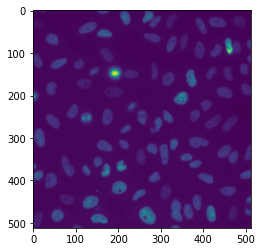

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(all_tracks[0].X[1][0])

In [39]:
all_tracks[0].appearances.shape

(11, 71, 168, 65, 64, 1)

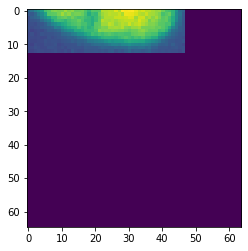

In [41]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][0][0])

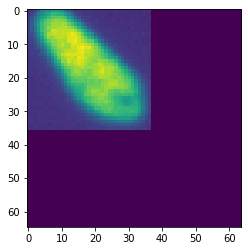

In [42]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][0][1])

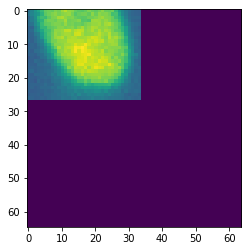

In [45]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][70][2])

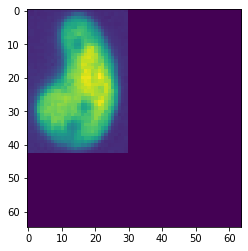

In [47]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[10][15][10])

In [48]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import io
import json
import os
import re
import tarfile
import tempfile

import numpy as np
import math

from scipy.spatial.distance import cdist

from skimage.measure import regionprops
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import resize


def clean_up_annotations(y, uid=None, data_format='channels_last'):
    """Relabels every frame in the label matrix.
    Args:
        y (np.array): annotations to relabel sequentially.
        uid (int, optional): starting ID to begin labeling cells.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        np.array: Cleaned up annotations.
    """
    y = y.astype('int32')
    time_axis = 1 if data_format == 'channels_first' else 0
    num_frames = y.shape[time_axis]

    all_uniques = []
    for f in range(num_frames):
        cells = np.unique(y[:, f] if data_format == 'channels_first' else y[f])
        cells = np.delete(cells, np.where(cells == 0))
        all_uniques.append(cells)

    # The annotations need to be unique across all frames
    uid = sum(len(x) for x in all_uniques) + 1 if uid is None else uid
    for frame, unique_cells in zip(range(num_frames), all_uniques):
        y_frame = y[:, frame] if data_format == 'channels_first' else y[frame]
        y_frame_new = np.zeros(y_frame.shape)
        for cell_label in unique_cells:
            y_frame_new[y_frame == cell_label] = uid
            uid += 1
        if data_format == 'channels_first':
            y[:, frame] = y_frame_new
        else:
            y[frame] = y_frame_new
    return y


def count_pairs(y, same_probability=0.5, data_format='channels_last'):
    """Compute number of training samples needed to observe all cell pairs.
    Args:
        y (np.array): 5D tensor of cell labels.
        same_probability (float): liklihood that 2 cells are the same.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        int: the total pairs needed to sample to see all possible pairings.
    """
    total_pairs = 0
    zaxis = 2 if data_format == 'channels_first' else 1
    for b in range(y.shape[0]):
        # count the number of cells in each image of the batch
        cells_per_image = []
        for f in range(y.shape[zaxis]):
            if data_format == 'channels_first':
                num_cells = len(np.unique(y[b, :, f, :, :]))
            else:
                num_cells = len(np.unique(y[b, f, :, :, :]))
            cells_per_image.append(num_cells)

        # Since there are many more possible non-self pairings than there
        # are self pairings, we want to estimate the number of possible
        # non-self pairings and then multiply that number by two, since the
        # odds of getting a non-self pairing are 50%, to find out how many
        # pairs we would need to sample to (statistically speaking) observe
        # all possible cell-frame pairs. We're going to assume that the
        # average cell is present in every frame. This will lead to an
        # underestimate of the number of possible non-self pairings, but it
        # is unclear how significant the underestimate is.
        average_cells_per_frame = sum(cells_per_image) // y.shape[zaxis]
        non_self_cellframes = (average_cells_per_frame - 1) * y.shape[zaxis]
        non_self_pairings = non_self_cellframes * max(cells_per_image)

        # Multiply cell pairings by 2 since the
        # odds of getting a non-self pairing are 50%
        cell_pairings = non_self_pairings // same_probability
        # Add this batch cell-pairings to the total count
        total_pairs += cell_pairings
    return total_pairs


def load_trks(filename):
    """Load a trk/trks file.
    Args:
        filename (str): full path to the file including .trk/.trks.
    Returns:
        dict: A dictionary with raw, tracked, and lineage data.
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = io.BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = io.BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

        # trks.extractfile opens a file in bytes mode, json can't use bytes.
        _, file_extension = os.path.splitext(filename)

        if file_extension == '.trks':
            trk_data = trks.getmember('lineages.json')
            lineages = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            for i, tracks in enumerate(lineages):
                lineages[i] = {int(k): v for k, v in tracks.items()}

        elif file_extension == '.trk':
            trk_data = trks.getmember('lineage.json')
            lineage = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            lineages = []
            lineages.append({int(k): v for k, v in lineage.items()})

    return {'lineages': lineages, 'X': raw, 'y': tracked}


def trk_folder_to_trks(dirname, trks_filename):
    """Compiles a directory of trk files into one trks_file.
    Args:
        dirname (str): full path to the directory containing multiple trk files.
        trks_filename (str): desired filename (the name should end in .trks).
    """
    lineages = []
    raw = []
    tracked = []

    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    file_list = os.listdir(dirname)
    file_list_sorted = sorted(file_list, key=alphanum_key)

    for filename in file_list_sorted:
        trk = load_trks(os.path.join(dirname, filename))
        lineages.append(trk['lineages'][0])  # this is loading a single track
        raw.append(trk['X'])
        tracked.append(trk['y'])

    file_path = os.path.join(os.path.dirname(dirname), trks_filename)

    save_trks(file_path, lineages, raw, tracked)


def save_trks(filename, lineages, raw, tracked):
    """Saves raw, tracked, and lineage data into one trks_file.
    Args:
        filename (str): full path to the final trk files.
        lineages (dict): a list of dictionaries saved as a json.
        raw (np.array): raw images data.
        tracked (np.array): annotated image data.
    Raises:
        ValueError: filename does not end in ".trks".
    """
    if not str(filename).lower().endswith('.trks'):
        raise ValueError('filename must end with `.trks`. Found %s' % filename)

    with tarfile.open(filename, 'w:gz') as trks:
        with tempfile.NamedTemporaryFile('w', delete=False) as lineages_file:
            json.dump(lineages, lineages_file, indent=4)
            lineages_file.flush()
            lineages_file.close()
            trks.add(lineages_file.name, 'lineages.json')
            os.remove(lineages_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            raw_file.close()
            trks.add(raw_file.name, 'raw.npy')
            os.remove(raw_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as tracked_file:
            np.save(tracked_file, tracked)
            tracked_file.flush()
            tracked_file.close()
            trks.add(tracked_file.name, 'tracked.npy')
            os.remove(tracked_file.name)


def trks_stats(filename):
    """For a given trks_file, find the Number of cell tracks,
       the Number of frames per track, and the Number of divisions.
    Args:
        filename (str): full path to a trks file.
    Raises:
        ValueError: filename is not a .trk or .trks file.
    """
    ext = os.path.splitext(filename)[-1].lower()
    if ext not in {'.trks', '.trk'}:
        raise ValueError('`trks_stats` expects a .trk or .trks but found a ' +
                         str(ext))

    training_data = load_trks(filename)
    X = training_data['X']
    y = training_data['y']
    daughters = [{cell: fields['daughters']
                  for cell, fields in tracks.items()}
                 for tracks in training_data['lineages']]

    print('Dataset Statistics: ')
    print('Image data shape: ', X.shape)
    print('Number of lineages (should equal batch size): ',
          len(training_data['lineages']))

    # Calculate cell density
    frame_area = X.shape[2] * X.shape[3]

    avg_cells_in_frame = []
    for batch in range(y.shape[0]):
        num_cells_in_frame = []
        for frame in y[batch]:
            cells_in_frame = len(np.unique(frame)) - 1  # unique returns 0 (BKGD)
            num_cells_in_frame.append(cells_in_frame)
        avg_cells_in_frame.append(np.average(num_cells_in_frame))
    avg_cells_per_sq_pixel = np.average(avg_cells_in_frame) / frame_area

    # Calculate division information
    total_tracks = 0
    total_divisions = 0
    avg_frame_counts_in_batches = []
    for batch, daughter_batch in enumerate(daughters):
        num_tracks_in_batch = len(daughter_batch)
        num_div_in_batch = len([c for c in daughter_batch if daughter_batch[c]])
        total_tracks = total_tracks + num_tracks_in_batch
        total_divisions = total_divisions + num_div_in_batch
        frame_counts = []
        for cell_id in daughter_batch.keys():
            frame_count = 0
            for frame in y[batch]:
                cells_in_frame = np.unique(frame)
                if cell_id in cells_in_frame:
                    frame_count += 1
            frame_counts.append(frame_count)
        avg_frame_counts_in_batches.append(np.average(frame_counts))
    avg_num_frames_per_track = np.average(avg_frame_counts_in_batches)

    print('Total number of unique tracks (cells)      - ', total_tracks)
    print('Total number of divisions                  - ', total_divisions)
    print('Average cell density (cells/100 sq pixels) - ', avg_cells_per_sq_pixel * 100)
    print('Average number of frames per track         - ', int(avg_num_frames_per_track))


def get_max_cells(y):
    """Helper function for finding the maximum number of cells in a frame of a movie, across
    all frames of the movie. Can be used for batches/tracks interchangeably with frames/cells.
    Args:
        y (np.array): Annotated image data
    Returns:
        int: The maximum number of cells in any frame
    """
    max_cells = 0
    for frame in range(y.shape[0]):
        cells = np.unique(y[frame])
        n_cells = cells[cells != 0].shape[0]
        if n_cells > max_cells:
            max_cells = n_cells
    return max_cells


def normalize_adj_matrix(adj, epsilon=1e-5):
    """Normalize the adjacency matrix
    Args:
        adj (np.array): Adjacency matrix
        epsilon (float): Used to create the degree matrix
    Returns:
        np.array: Normalized adjacency matrix
    Raises:
        ValueError: If ``adj`` has a rank that is not 3 or 4.
    """
    input_rank = len(adj.shape)
    if input_rank not in {3, 4}:
        raise ValueError('Only 3 & 4 dim adjacency matrices are supported')

    if input_rank == 3:
        # temporarily include a batch dimension for consistent processing
        adj = np.expand_dims(adj, axis=0)

    normalized_adj = np.zeros(adj.shape, dtype='float32')

    for t in range(adj.shape[1]):
        adj_frame = adj[:, t]
        # create degree matrix
        degrees = np.sum(adj_frame, axis=1)
        for batch, degree in enumerate(degrees):
            degree = (degree + epsilon) ** -0.5
            degree_matrix = np.diagflat(degree)

            normalized = np.matmul(degree_matrix, adj_frame[batch])
            normalized = np.matmul(normalized, degree_matrix)
            normalized_adj[batch, t] = normalized

    if input_rank == 3:
        # remove batch axis
        normalized_adj = normalized_adj[0]

    return normalized_adj


def relabel_sequential_lineage(y, lineage):
    """Ensure the lineage information is sequentially labeled.
    Args:
        y (np.array): Annotated z-stack of image labels.
        lineage (dict): Lineage data for y.
    Returns:
        tuple(np.array, dict): The relabeled array and corrected lineage.
    """
    y_relabel, fw, _ = relabel_sequential(y)

    new_lineage = {}

    cell_ids = np.unique(y)
    cell_ids = cell_ids[cell_ids != 0]
    for cell_id in cell_ids:
        new_cell_id = fw[cell_id]

        new_lineage[new_cell_id] = {}

        # Fix label
        # TODO: label == track ID?
        new_lineage[new_cell_id]['label'] = new_cell_id

        # Fix parent
        parent = lineage[cell_id]['parent']
        new_parent = fw[parent] if parent is not None else parent
        new_lineage[new_cell_id]['parent'] = new_parent

        # Fix daughters
        daughters = lineage[cell_id]['daughters']
        new_lineage[new_cell_id]['daughters'] = [fw[d] for d in daughters]

        # Fix frames
        y_true = np.sum(y == cell_id, axis=(1, 2))
        y_index = np.where(y_true > 0)[0]
        new_lineage[new_cell_id]['frames'] = list(y_index)

    return y_relabel, new_lineage


def is_valid_lineage(lineage):
    """Check if a cell lineage of a single movie is valid.
    Daughter cells must exist in the frame after the parent's final frame.
    Args:
        lineage (dict): The cell lineages for a single movie.
    Returns:
        bool: Whether or not the lineage is valid.
    """
    for cell_lineage in lineage.values():
        # Get last frame of parent
        last_parent_frame = cell_lineage['frames'][-1]

        for daughter in cell_lineage['daughters']:
            # get first frame of daughter
            first_daughter_frame = lineage[daughter]['frames'][0]

            # Check that daughter's start frame is one larger than parent end frame
            if first_daughter_frame - last_parent_frame != 1:
                return False

    return True  # all cell lineages are valid!

def get_appearance_dimensions(X_arr, y_arr):
    """Get the dimensions of the appearance images.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        tuple: A tuple of dimensions of shape (2)."""
    app_rows = 0
    app_cols = 0
    
    n_batches = X_arr.shape[0]
    n_frames = X_arr.shape[1]
    
    for batch in range(n_batches):
        for frame in range(n_frames):
            y = y_arr[batch, frame]
            props = regionprops(y[..., 0], cache=False)
            for prop in props:
                # Get appearance dimensions
                minr, minc, maxr, maxc = prop.bbox
                row = maxr - minr
                col = maxc - minc
                if row > app_rows:
                    app_rows = row
                if col > app_cols:
                    app_cols = col

    return app_rows, app_cols


def get_image_features(X, y, app_rows, app_cols):
    """Return features for every object in the array.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        dict: A dictionary of feature names to np.arrays of shape
            (n, c) or (n, x, y, c) where n is the number of objects.
    """

    # each feature will be ordered based on the label.
    # labels are also stored and can be fetched by index.
    num_labels = len(np.unique(y)) - 1
    labels = np.zeros((num_labels,), dtype='int32')
    centroids = np.zeros((num_labels, 2), dtype='float32')
    morphologies = np.zeros((num_labels, 3), dtype='float32')
    
    app_rows = int(app_rows)
    app_cols = int(app_cols)

    appearances = np.zeros((num_labels, app_rows, app_cols, X.shape[-1]),
                            dtype='float32')

    # iterate over all objects in y
    props = regionprops(y[..., 0], cache=False)
    for i, prop in enumerate(props):
        # Get label
        labels[i] = prop.label

        # Get centroid
        centroid = np.array(prop.centroid)
        centroids[i] = centroid

        # Get morphology
        morphology = np.array([
            prop.area,
            prop.perimeter,
            prop.eccentricity
        ])
        morphologies[i] = morphology

        # Get appearance
        minr, minc, maxr, maxc = prop.bbox

        rows = maxr - minr
        cols = maxc - minc

        centr = app_rows / 2
        centc = app_cols / 2

        lowr = math.floor(centr - rows / 2)
        highr = math.floor(centr + rows / 2)
        lowc = math.floor(centc - cols / 2)
        highc = math.floor(centc + cols / 2)

        appearance = np.zeros((app_rows, app_cols, X.shape[-1]), dtype='float32')

        label = prop.label
        for r in range(lowr, highr):
            for c in range(lowc, highc):
                for n in range(X.shape[-1]):
                    """
                    pixel = X[minr + (r - lowr), minc + (c - lowc), n]
                    if pixel == label:
                        appearance[r, c, n] = pixel
                    else:
                        appearance[r, c, n] = 0
                    """
                    pixel = X[minr + (r - lowr), minc + (c - lowc), n]
                    appearance[r, c, n] = pixel

        appearances[i] = appearance  

    # Get adjacency matrix
    # distance = cdist(centroids, centroids, metric='euclidean') < distance_threshold
    # adj_matrix = distance.astype('float32')

    return {
        'appearances': appearances,
        'centroids': centroids,
        'labels': labels,
        'morphologies': morphologies,
        # 'adj_matrix': adj_matrix,
    }


def concat_tracks(tracks):
    """Join an iterable of Track objects into a single dictionary of features.
    Args:
        tracks (iterable): Iterable of tracks.
    Returns:
        dict: A dictionary of tracked features.
    Raises:
        TypeError: ``tracks`` is not iterable.
    """
    try:
        list(tracks)  # check if iterable
    except TypeError:
        raise TypeError('concatenate_tracks requires an iterable input.')

    def get_array_of_max_shape(lst):
        # find max dimensions of all arrs in lst.
        shape = None
        size = 0
        for arr in lst:
            if shape is None:
                shape = [0] * len(arr.shape[1:])
            for i, dim in enumerate(arr.shape[1:]):
                if dim > shape[i]:
                    shape[i] = dim
            size += arr.shape[0]
        # add batch dimension
        shape = [size] + shape
        return np.zeros(shape, dtype='float32')

    # insert small array into larger array
    # https://stackoverflow.com/a/50692782
    def paste_slices(tup):
        pos, w, max_w = tup
        wall_min = max(pos, 0)
        wall_max = min(pos + w, max_w)
        block_min = -min(pos, 0)
        block_max = max_w - max(pos + w, max_w)
        block_max = block_max if block_max != 0 else None
        return slice(wall_min, wall_max), slice(block_min, block_max)

    def paste(wall, block, loc):
        loc_zip = zip(loc, block.shape, wall.shape)
        wall_slices, block_slices = zip(*map(paste_slices, loc_zip))
        wall[wall_slices] = block[block_slices]

    # TODO: these keys must match the Track attributes.
    track_info = {
        'appearances': get_array_of_max_shape((t.appearances for t in tracks)),
        'centroids': get_array_of_max_shape((t.centroids for t in tracks)),
        'morphologies': get_array_of_max_shape((t.morphologies for t in tracks)),
        'adj_matrices': get_array_of_max_shape((t.adj_matrices for t in tracks)),
        'norm_adj_matrices': get_array_of_max_shape(
            (t.norm_adj_matrices for t in tracks)),
        'temporal_adj_matrices': get_array_of_max_shape(
            (t.temporal_adj_matrices for t in tracks))
    }

    for track in tracks:
        for k in track_info:
            feature = getattr(track, k)
            paste(track_info[k], feature, (0,) * len(feature.shape))

    return track_info


class Track(object):  # pylint: disable=useless-object-inheritance

    def __init__(self, path=None, tracked_data=None, distance_threshold=64):
        if tracked_data:
            training_data = tracked_data
        elif path:
            training_data = load_trks(path)
        else:
            raise ValueError('One of `tracked_data` or `path` is required')
        self.X = training_data['X'].astype('float32')
        self.y = training_data['y'].astype('int32')
        self.lineages = training_data['lineages']
        self.distance_threshold = distance_threshold

        # Correct lineages
        self._correct_lineages()

        # Remove bad batches
        self._remove_invalid_batches()

        # Create feature dictionaries
        features_dict = self._get_features()
        self.appearances = features_dict['appearances']
        self.morphologies = features_dict['morphologies']
        self.centroids = features_dict['centroids']
        self.adj_matrices = features_dict['adj_matrix']
        self.norm_adj_matrices = normalize_adj_matrix(self.adj_matrices)
        self.temporal_adj_matrices = features_dict['temporal_adj_matrix']
        self.mask = features_dict['mask']
        self.track_length = features_dict['track_length']

    def _correct_lineages(self):
        """Ensure sequential labels for all batches"""
        new_lineages = {}
        for batch in range(self.y.shape[0]):

            y_relabel, new_lineage = relabel_sequential_lineage(
                self.y[batch], self.lineages[batch])

            new_lineages[batch] = new_lineage
            self.y[batch] = y_relabel

        self.lineages = new_lineages

    def _remove_invalid_batches(self):
        """Remove all movies and lineages that are invalid.
        All batches with a daughter cell starting in a frame
        other than the parent's final frame will be dropped.
        """
        bad_batches = set()

        for batch in range(self.y.shape[0]):
            if not is_valid_lineage(self.lineages[batch]):
                bad_batches.add(batch)

        new_X = []
        new_y = []
        new_lineages = []
        for batch in range(self.X.shape[0]):
            if batch not in bad_batches:
                new_X.append(self.X[batch])
                new_y.append(self.y[batch])
                new_lineages.append(self.lineages[batch])

        self.X = np.stack(new_X, axis=0)
        self.y = np.stack(new_y, axis=0)
        self.lineages = new_lineages

    def _get_features(self):
        """
        Extract the relevant features from the label movie
        Appearance, morphologies, centroids, and adjacency matrices
        """
        max_tracks = get_max_cells(self.y)
        n_batches = self.X.shape[0]
        n_frames = self.X.shape[1]
        n_channels = self.X.shape[-1]

        batch_shape = (n_batches, n_frames, max_tracks)

        app_rows, app_cols = get_appearance_dimensions(self.X, self.y)
        app_rows = int(app_rows)
        app_cols = int(app_cols)
        
        appearance_shape = (app_rows, app_cols, n_channels)

        appearances = np.zeros(batch_shape + appearance_shape, dtype='float32')

        morphologies = np.zeros(batch_shape + (3,), dtype='float32')

        centroids = np.zeros(batch_shape + (2,), dtype='float32')

        adj_matrix = np.zeros(batch_shape + (max_tracks,), dtype='float32')

        temporal_adj_matrix = np.zeros((n_batches,
                                        n_frames - 1,
                                        max_tracks,
                                        max_tracks,
                                        3), dtype='float32')

        mask = np.zeros(batch_shape, dtype='float32')

        track_length = np.zeros((n_batches, max_tracks, 2), dtype='int32')

        for batch in range(n_batches):
            for frame in range(n_frames):

                frame_features = get_image_features(
                    self.X[batch, frame], self.y[batch, frame], app_rows, app_cols)

                track_ids = frame_features['labels'] - 1
                centroids[batch, frame, track_ids] = frame_features['centroids']
                morphologies[batch, frame, track_ids] = frame_features['morphologies']
                appearances[batch, frame, track_ids] = frame_features['appearances']
                mask[batch, frame, track_ids] = 1

                # Get adjacency matrix, cannot filter on track ids.
                cent = centroids[batch, frame]
                distance = cdist(cent, cent, metric='euclidean')
                distance = distance < self.distance_threshold
                adj_matrix[batch, frame] = distance.astype(np.float32)

            # Get track length and temporal adjacency matrix
            for label in self.lineages[batch]:
                # Get track length
                start_frame = self.lineages[batch][label]['frames'][0]
                end_frame = self.lineages[batch][label]['frames'][-1]

                track_id = label - 1
                track_length[batch, track_id, 0] = start_frame
                track_length[batch, track_id, 1] = end_frame

                # Get temporal adjacency matrix
                frames = self.lineages[batch][label]['frames']

                # Assign same
                for f0, f1 in zip(frames[0:-1], frames[1:]):
                    if f1 - f0 == 1:
                        temporal_adj_matrix[batch, f0, track_id, track_id, 0] = 1

                # Assign daughter
                # WARNING: This wont work if there's a time gap between mother
                # cell disappearing and daughter cells appearing
                last_frame = frames[-1]
                daughters = self.lineages[batch][label]['daughters']
                for daughter in daughters:
                    daughter_id = daughter - 1
                    temporal_adj_matrix[batch, last_frame, track_id, daughter_id, 2] = 1

            # Assign different
            same_prob = temporal_adj_matrix[batch, ..., 0]
            daughter_prob = temporal_adj_matrix[batch, ..., 2]
            temporal_adj_matrix[batch, ..., 1] = 1 - same_prob - daughter_prob

            # Identify padding
            for i in range(temporal_adj_matrix.shape[2]):
                # index + 1 is the cell label
                if i + 1 not in self.lineages[batch]:
                    temporal_adj_matrix[batch, :, i] = -1
                    temporal_adj_matrix[batch, :, :, i] = -1

        feature_dict = {}
        feature_dict['adj_matrix'] = adj_matrix
        feature_dict['appearances'] = appearances
        feature_dict['morphologies'] = morphologies
        feature_dict['centroids'] = centroids
        feature_dict['temporal_adj_matrix'] = temporal_adj_matrix
        feature_dict['mask'] = mask
        feature_dict['track_length'] = track_length

        return feature_dict

In [49]:
%%time
path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

CPU times: user 347 ms, sys: 928 ms, total: 1.27 s
Wall time: 1.28 s


In [50]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 3min 13s, sys: 6.29 s, total: 3min 19s
Wall time: 3min 8s


In [52]:
len(all_tracks)

1

In [53]:
all_tracks[0].X.shape

(11, 71, 512, 512, 1)

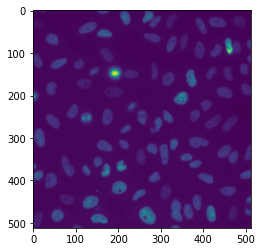

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(all_tracks[0].X[1][0])

In [55]:
all_tracks[0].appearances.shape

(11, 71, 168, 65, 64, 1)

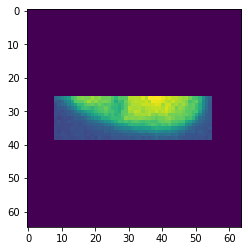

In [56]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][0][0])

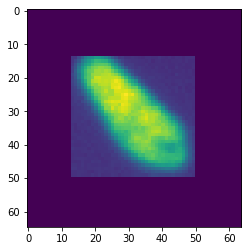

In [57]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][0][1])

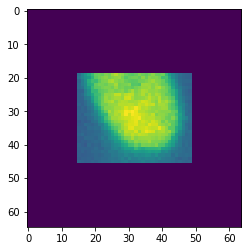

In [58]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][70][2])

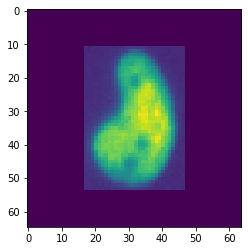

In [59]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[10][15][10])

In [60]:
# Correct implementation

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import io
import json
import os
import re
import tarfile
import tempfile

import numpy as np
import math

from scipy.spatial.distance import cdist

from skimage.measure import regionprops
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import resize


def clean_up_annotations(y, uid=None, data_format='channels_last'):
    """Relabels every frame in the label matrix.
    Args:
        y (np.array): annotations to relabel sequentially.
        uid (int, optional): starting ID to begin labeling cells.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        np.array: Cleaned up annotations.
    """
    y = y.astype('int32')
    time_axis = 1 if data_format == 'channels_first' else 0
    num_frames = y.shape[time_axis]

    all_uniques = []
    for f in range(num_frames):
        cells = np.unique(y[:, f] if data_format == 'channels_first' else y[f])
        cells = np.delete(cells, np.where(cells == 0))
        all_uniques.append(cells)

    # The annotations need to be unique across all frames
    uid = sum(len(x) for x in all_uniques) + 1 if uid is None else uid
    for frame, unique_cells in zip(range(num_frames), all_uniques):
        y_frame = y[:, frame] if data_format == 'channels_first' else y[frame]
        y_frame_new = np.zeros(y_frame.shape)
        for cell_label in unique_cells:
            y_frame_new[y_frame == cell_label] = uid
            uid += 1
        if data_format == 'channels_first':
            y[:, frame] = y_frame_new
        else:
            y[frame] = y_frame_new
    return y


def count_pairs(y, same_probability=0.5, data_format='channels_last'):
    """Compute number of training samples needed to observe all cell pairs.
    Args:
        y (np.array): 5D tensor of cell labels.
        same_probability (float): liklihood that 2 cells are the same.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        int: the total pairs needed to sample to see all possible pairings.
    """
    total_pairs = 0
    zaxis = 2 if data_format == 'channels_first' else 1
    for b in range(y.shape[0]):
        # count the number of cells in each image of the batch
        cells_per_image = []
        for f in range(y.shape[zaxis]):
            if data_format == 'channels_first':
                num_cells = len(np.unique(y[b, :, f, :, :]))
            else:
                num_cells = len(np.unique(y[b, f, :, :, :]))
            cells_per_image.append(num_cells)

        # Since there are many more possible non-self pairings than there
        # are self pairings, we want to estimate the number of possible
        # non-self pairings and then multiply that number by two, since the
        # odds of getting a non-self pairing are 50%, to find out how many
        # pairs we would need to sample to (statistically speaking) observe
        # all possible cell-frame pairs. We're going to assume that the
        # average cell is present in every frame. This will lead to an
        # underestimate of the number of possible non-self pairings, but it
        # is unclear how significant the underestimate is.
        average_cells_per_frame = sum(cells_per_image) // y.shape[zaxis]
        non_self_cellframes = (average_cells_per_frame - 1) * y.shape[zaxis]
        non_self_pairings = non_self_cellframes * max(cells_per_image)

        # Multiply cell pairings by 2 since the
        # odds of getting a non-self pairing are 50%
        cell_pairings = non_self_pairings // same_probability
        # Add this batch cell-pairings to the total count
        total_pairs += cell_pairings
    return total_pairs


def load_trks(filename):
    """Load a trk/trks file.
    Args:
        filename (str): full path to the file including .trk/.trks.
    Returns:
        dict: A dictionary with raw, tracked, and lineage data.
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = io.BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = io.BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

        # trks.extractfile opens a file in bytes mode, json can't use bytes.
        _, file_extension = os.path.splitext(filename)

        if file_extension == '.trks':
            trk_data = trks.getmember('lineages.json')
            lineages = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            for i, tracks in enumerate(lineages):
                lineages[i] = {int(k): v for k, v in tracks.items()}

        elif file_extension == '.trk':
            trk_data = trks.getmember('lineage.json')
            lineage = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            lineages = []
            lineages.append({int(k): v for k, v in lineage.items()})

    return {'lineages': lineages, 'X': raw, 'y': tracked}


def trk_folder_to_trks(dirname, trks_filename):
    """Compiles a directory of trk files into one trks_file.
    Args:
        dirname (str): full path to the directory containing multiple trk files.
        trks_filename (str): desired filename (the name should end in .trks).
    """
    lineages = []
    raw = []
    tracked = []

    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    file_list = os.listdir(dirname)
    file_list_sorted = sorted(file_list, key=alphanum_key)

    for filename in file_list_sorted:
        trk = load_trks(os.path.join(dirname, filename))
        lineages.append(trk['lineages'][0])  # this is loading a single track
        raw.append(trk['X'])
        tracked.append(trk['y'])

    file_path = os.path.join(os.path.dirname(dirname), trks_filename)

    save_trks(file_path, lineages, raw, tracked)


def save_trks(filename, lineages, raw, tracked):
    """Saves raw, tracked, and lineage data into one trks_file.
    Args:
        filename (str): full path to the final trk files.
        lineages (dict): a list of dictionaries saved as a json.
        raw (np.array): raw images data.
        tracked (np.array): annotated image data.
    Raises:
        ValueError: filename does not end in ".trks".
    """
    if not str(filename).lower().endswith('.trks'):
        raise ValueError('filename must end with `.trks`. Found %s' % filename)

    with tarfile.open(filename, 'w:gz') as trks:
        with tempfile.NamedTemporaryFile('w', delete=False) as lineages_file:
            json.dump(lineages, lineages_file, indent=4)
            lineages_file.flush()
            lineages_file.close()
            trks.add(lineages_file.name, 'lineages.json')
            os.remove(lineages_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            raw_file.close()
            trks.add(raw_file.name, 'raw.npy')
            os.remove(raw_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as tracked_file:
            np.save(tracked_file, tracked)
            tracked_file.flush()
            tracked_file.close()
            trks.add(tracked_file.name, 'tracked.npy')
            os.remove(tracked_file.name)


def trks_stats(filename):
    """For a given trks_file, find the Number of cell tracks,
       the Number of frames per track, and the Number of divisions.
    Args:
        filename (str): full path to a trks file.
    Raises:
        ValueError: filename is not a .trk or .trks file.
    """
    ext = os.path.splitext(filename)[-1].lower()
    if ext not in {'.trks', '.trk'}:
        raise ValueError('`trks_stats` expects a .trk or .trks but found a ' +
                         str(ext))

    training_data = load_trks(filename)
    X = training_data['X']
    y = training_data['y']
    daughters = [{cell: fields['daughters']
                  for cell, fields in tracks.items()}
                 for tracks in training_data['lineages']]

    print('Dataset Statistics: ')
    print('Image data shape: ', X.shape)
    print('Number of lineages (should equal batch size): ',
          len(training_data['lineages']))

    # Calculate cell density
    frame_area = X.shape[2] * X.shape[3]

    avg_cells_in_frame = []
    for batch in range(y.shape[0]):
        num_cells_in_frame = []
        for frame in y[batch]:
            cells_in_frame = len(np.unique(frame)) - 1  # unique returns 0 (BKGD)
            num_cells_in_frame.append(cells_in_frame)
        avg_cells_in_frame.append(np.average(num_cells_in_frame))
    avg_cells_per_sq_pixel = np.average(avg_cells_in_frame) / frame_area

    # Calculate division information
    total_tracks = 0
    total_divisions = 0
    avg_frame_counts_in_batches = []
    for batch, daughter_batch in enumerate(daughters):
        num_tracks_in_batch = len(daughter_batch)
        num_div_in_batch = len([c for c in daughter_batch if daughter_batch[c]])
        total_tracks = total_tracks + num_tracks_in_batch
        total_divisions = total_divisions + num_div_in_batch
        frame_counts = []
        for cell_id in daughter_batch.keys():
            frame_count = 0
            for frame in y[batch]:
                cells_in_frame = np.unique(frame)
                if cell_id in cells_in_frame:
                    frame_count += 1
            frame_counts.append(frame_count)
        avg_frame_counts_in_batches.append(np.average(frame_counts))
    avg_num_frames_per_track = np.average(avg_frame_counts_in_batches)

    print('Total number of unique tracks (cells)      - ', total_tracks)
    print('Total number of divisions                  - ', total_divisions)
    print('Average cell density (cells/100 sq pixels) - ', avg_cells_per_sq_pixel * 100)
    print('Average number of frames per track         - ', int(avg_num_frames_per_track))


def get_max_cells(y):
    """Helper function for finding the maximum number of cells in a frame of a movie, across
    all frames of the movie. Can be used for batches/tracks interchangeably with frames/cells.
    Args:
        y (np.array): Annotated image data
    Returns:
        int: The maximum number of cells in any frame
    """
    max_cells = 0
    for frame in range(y.shape[0]):
        cells = np.unique(y[frame])
        n_cells = cells[cells != 0].shape[0]
        if n_cells > max_cells:
            max_cells = n_cells
    return max_cells


def normalize_adj_matrix(adj, epsilon=1e-5):
    """Normalize the adjacency matrix
    Args:
        adj (np.array): Adjacency matrix
        epsilon (float): Used to create the degree matrix
    Returns:
        np.array: Normalized adjacency matrix
    Raises:
        ValueError: If ``adj`` has a rank that is not 3 or 4.
    """
    input_rank = len(adj.shape)
    if input_rank not in {3, 4}:
        raise ValueError('Only 3 & 4 dim adjacency matrices are supported')

    if input_rank == 3:
        # temporarily include a batch dimension for consistent processing
        adj = np.expand_dims(adj, axis=0)

    normalized_adj = np.zeros(adj.shape, dtype='float32')

    for t in range(adj.shape[1]):
        adj_frame = adj[:, t]
        # create degree matrix
        degrees = np.sum(adj_frame, axis=1)
        for batch, degree in enumerate(degrees):
            degree = (degree + epsilon) ** -0.5
            degree_matrix = np.diagflat(degree)

            normalized = np.matmul(degree_matrix, adj_frame[batch])
            normalized = np.matmul(normalized, degree_matrix)
            normalized_adj[batch, t] = normalized

    if input_rank == 3:
        # remove batch axis
        normalized_adj = normalized_adj[0]

    return normalized_adj


def relabel_sequential_lineage(y, lineage):
    """Ensure the lineage information is sequentially labeled.
    Args:
        y (np.array): Annotated z-stack of image labels.
        lineage (dict): Lineage data for y.
    Returns:
        tuple(np.array, dict): The relabeled array and corrected lineage.
    """
    y_relabel, fw, _ = relabel_sequential(y)

    new_lineage = {}

    cell_ids = np.unique(y)
    cell_ids = cell_ids[cell_ids != 0]
    for cell_id in cell_ids:
        new_cell_id = fw[cell_id]

        new_lineage[new_cell_id] = {}

        # Fix label
        # TODO: label == track ID?
        new_lineage[new_cell_id]['label'] = new_cell_id

        # Fix parent
        parent = lineage[cell_id]['parent']
        new_parent = fw[parent] if parent is not None else parent
        new_lineage[new_cell_id]['parent'] = new_parent

        # Fix daughters
        daughters = lineage[cell_id]['daughters']
        new_lineage[new_cell_id]['daughters'] = [fw[d] for d in daughters]

        # Fix frames
        y_true = np.sum(y == cell_id, axis=(1, 2))
        y_index = np.where(y_true > 0)[0]
        new_lineage[new_cell_id]['frames'] = list(y_index)

    return y_relabel, new_lineage


def is_valid_lineage(lineage):
    """Check if a cell lineage of a single movie is valid.
    Daughter cells must exist in the frame after the parent's final frame.
    Args:
        lineage (dict): The cell lineages for a single movie.
    Returns:
        bool: Whether or not the lineage is valid.
    """
    for cell_lineage in lineage.values():
        # Get last frame of parent
        last_parent_frame = cell_lineage['frames'][-1]

        for daughter in cell_lineage['daughters']:
            # get first frame of daughter
            first_daughter_frame = lineage[daughter]['frames'][0]

            # Check that daughter's start frame is one larger than parent end frame
            if first_daughter_frame - last_parent_frame != 1:
                return False

    return True  # all cell lineages are valid!

def get_appearance_dimensions(X_arr, y_arr):
    """Get the dimensions of the appearance images.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        tuple: A tuple of dimensions of shape (2)."""
    app_rows = 0
    app_cols = 0
    
    n_batches = X_arr.shape[0]
    n_frames = X_arr.shape[1]
    
    for batch in range(n_batches):
        for frame in range(n_frames):
            y = y_arr[batch, frame]
            props = regionprops(y[..., 0], cache=False)
            for prop in props:
                # Get appearance dimensions
                minr, minc, maxr, maxc = prop.bbox
                row = maxr - minr
                col = maxc - minc
                if row > app_rows:
                    app_rows = row
                if col > app_cols:
                    app_cols = col

    return app_rows, app_cols


def get_image_features(X, y, app_rows, app_cols):
    """Return features for every object in the array.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        dict: A dictionary of feature names to np.arrays of shape
            (n, c) or (n, x, y, c) where n is the number of objects.
    """

    # each feature will be ordered based on the label.
    # labels are also stored and can be fetched by index.
    num_labels = len(np.unique(y)) - 1
    labels = np.zeros((num_labels,), dtype='int32')
    centroids = np.zeros((num_labels, 2), dtype='float32')
    morphologies = np.zeros((num_labels, 3), dtype='float32')
    
    app_rows = int(app_rows)
    app_cols = int(app_cols)

    appearances = np.zeros((num_labels, app_rows, app_cols, X.shape[-1]),
                            dtype='float32')

    # iterate over all objects in y
    props = regionprops(y[..., 0], cache=False)
    for i, prop in enumerate(props):
        # Get label
        labels[i] = prop.label

        # Get centroid
        centroid = np.array(prop.centroid)
        centroids[i] = centroid

        # Get morphology
        morphology = np.array([
            prop.area,
            prop.perimeter,
            prop.eccentricity
        ])
        morphologies[i] = morphology

        # Get appearance
        minr, minc, maxr, maxc = prop.bbox

        rows = maxr - minr
        cols = maxc - minc

        centr = app_rows / 2
        centc = app_cols / 2

        lowr = math.floor(centr - rows / 2)
        highr = math.floor(centr + rows / 2)
        lowc = math.floor(centc - cols / 2)
        highc = math.floor(centc + cols / 2)

        appearance = np.zeros((app_rows, app_cols, X.shape[-1]), dtype='float32')

        label = prop.label
        for r in range(lowr, highr):
            for c in range(lowc, highc):
                for n in range(X.shape[-1]):
                    pixel = X[minr + (r - lowr), minc + (c - lowc), n]
                    label_pixel = y[minr + (r - lowr), minc + (c - lowc), n]
                    
                    if label_pixel == label:
                        appearance[r, c, n] = pixel
                    else:
                        appearance[r, c, n] = 0

        appearances[i] = appearance  

    # Get adjacency matrix
    # distance = cdist(centroids, centroids, metric='euclidean') < distance_threshold
    # adj_matrix = distance.astype('float32')

    return {
        'appearances': appearances,
        'centroids': centroids,
        'labels': labels,
        'morphologies': morphologies,
        # 'adj_matrix': adj_matrix,
    }


def concat_tracks(tracks):
    """Join an iterable of Track objects into a single dictionary of features.
    Args:
        tracks (iterable): Iterable of tracks.
    Returns:
        dict: A dictionary of tracked features.
    Raises:
        TypeError: ``tracks`` is not iterable.
    """
    try:
        list(tracks)  # check if iterable
    except TypeError:
        raise TypeError('concatenate_tracks requires an iterable input.')

    def get_array_of_max_shape(lst):
        # find max dimensions of all arrs in lst.
        shape = None
        size = 0
        for arr in lst:
            if shape is None:
                shape = [0] * len(arr.shape[1:])
            for i, dim in enumerate(arr.shape[1:]):
                if dim > shape[i]:
                    shape[i] = dim
            size += arr.shape[0]
        # add batch dimension
        shape = [size] + shape
        return np.zeros(shape, dtype='float32')

    # insert small array into larger array
    # https://stackoverflow.com/a/50692782
    def paste_slices(tup):
        pos, w, max_w = tup
        wall_min = max(pos, 0)
        wall_max = min(pos + w, max_w)
        block_min = -min(pos, 0)
        block_max = max_w - max(pos + w, max_w)
        block_max = block_max if block_max != 0 else None
        return slice(wall_min, wall_max), slice(block_min, block_max)

    def paste(wall, block, loc):
        loc_zip = zip(loc, block.shape, wall.shape)
        wall_slices, block_slices = zip(*map(paste_slices, loc_zip))
        wall[wall_slices] = block[block_slices]

    # TODO: these keys must match the Track attributes.
    track_info = {
        'appearances': get_array_of_max_shape((t.appearances for t in tracks)),
        'centroids': get_array_of_max_shape((t.centroids for t in tracks)),
        'morphologies': get_array_of_max_shape((t.morphologies for t in tracks)),
        'adj_matrices': get_array_of_max_shape((t.adj_matrices for t in tracks)),
        'norm_adj_matrices': get_array_of_max_shape(
            (t.norm_adj_matrices for t in tracks)),
        'temporal_adj_matrices': get_array_of_max_shape(
            (t.temporal_adj_matrices for t in tracks))
    }

    for track in tracks:
        for k in track_info:
            feature = getattr(track, k)
            paste(track_info[k], feature, (0,) * len(feature.shape))

    return track_info


class Track(object):  # pylint: disable=useless-object-inheritance

    def __init__(self, path=None, tracked_data=None, distance_threshold=64):
        if tracked_data:
            training_data = tracked_data
        elif path:
            training_data = load_trks(path)
        else:
            raise ValueError('One of `tracked_data` or `path` is required')
        self.X = training_data['X'].astype('float32')
        self.y = training_data['y'].astype('int32')
        self.lineages = training_data['lineages']
        self.distance_threshold = distance_threshold

        # Correct lineages
        self._correct_lineages()

        # Remove bad batches
        self._remove_invalid_batches()

        # Create feature dictionaries
        features_dict = self._get_features()
        self.appearances = features_dict['appearances']
        self.morphologies = features_dict['morphologies']
        self.centroids = features_dict['centroids']
        self.adj_matrices = features_dict['adj_matrix']
        self.norm_adj_matrices = normalize_adj_matrix(self.adj_matrices)
        self.temporal_adj_matrices = features_dict['temporal_adj_matrix']
        self.mask = features_dict['mask']
        self.track_length = features_dict['track_length']

    def _correct_lineages(self):
        """Ensure sequential labels for all batches"""
        new_lineages = {}
        for batch in range(self.y.shape[0]):

            y_relabel, new_lineage = relabel_sequential_lineage(
                self.y[batch], self.lineages[batch])

            new_lineages[batch] = new_lineage
            self.y[batch] = y_relabel

        self.lineages = new_lineages

    def _remove_invalid_batches(self):
        """Remove all movies and lineages that are invalid.
        All batches with a daughter cell starting in a frame
        other than the parent's final frame will be dropped.
        """
        bad_batches = set()

        for batch in range(self.y.shape[0]):
            if not is_valid_lineage(self.lineages[batch]):
                bad_batches.add(batch)

        new_X = []
        new_y = []
        new_lineages = []
        for batch in range(self.X.shape[0]):
            if batch not in bad_batches:
                new_X.append(self.X[batch])
                new_y.append(self.y[batch])
                new_lineages.append(self.lineages[batch])

        self.X = np.stack(new_X, axis=0)
        self.y = np.stack(new_y, axis=0)
        self.lineages = new_lineages

    def _get_features(self):
        """
        Extract the relevant features from the label movie
        Appearance, morphologies, centroids, and adjacency matrices
        """
        max_tracks = get_max_cells(self.y)
        n_batches = self.X.shape[0]
        n_frames = self.X.shape[1]
        n_channels = self.X.shape[-1]

        batch_shape = (n_batches, n_frames, max_tracks)

        app_rows, app_cols = get_appearance_dimensions(self.X, self.y)
        app_rows = int(app_rows)
        app_cols = int(app_cols)
        
        appearance_shape = (app_rows, app_cols, n_channels)

        appearances = np.zeros(batch_shape + appearance_shape, dtype='float32')

        morphologies = np.zeros(batch_shape + (3,), dtype='float32')

        centroids = np.zeros(batch_shape + (2,), dtype='float32')

        adj_matrix = np.zeros(batch_shape + (max_tracks,), dtype='float32')

        temporal_adj_matrix = np.zeros((n_batches,
                                        n_frames - 1,
                                        max_tracks,
                                        max_tracks,
                                        3), dtype='float32')

        mask = np.zeros(batch_shape, dtype='float32')

        track_length = np.zeros((n_batches, max_tracks, 2), dtype='int32')

        for batch in range(n_batches):
            for frame in range(n_frames):

                frame_features = get_image_features(
                    self.X[batch, frame], self.y[batch, frame], app_rows, app_cols)

                track_ids = frame_features['labels'] - 1
                centroids[batch, frame, track_ids] = frame_features['centroids']
                morphologies[batch, frame, track_ids] = frame_features['morphologies']
                appearances[batch, frame, track_ids] = frame_features['appearances']
                mask[batch, frame, track_ids] = 1

                # Get adjacency matrix, cannot filter on track ids.
                cent = centroids[batch, frame]
                distance = cdist(cent, cent, metric='euclidean')
                distance = distance < self.distance_threshold
                adj_matrix[batch, frame] = distance.astype(np.float32)

            # Get track length and temporal adjacency matrix
            for label in self.lineages[batch]:
                # Get track length
                start_frame = self.lineages[batch][label]['frames'][0]
                end_frame = self.lineages[batch][label]['frames'][-1]

                track_id = label - 1
                track_length[batch, track_id, 0] = start_frame
                track_length[batch, track_id, 1] = end_frame

                # Get temporal adjacency matrix
                frames = self.lineages[batch][label]['frames']

                # Assign same
                for f0, f1 in zip(frames[0:-1], frames[1:]):
                    if f1 - f0 == 1:
                        temporal_adj_matrix[batch, f0, track_id, track_id, 0] = 1

                # Assign daughter
                # WARNING: This wont work if there's a time gap between mother
                # cell disappearing and daughter cells appearing
                last_frame = frames[-1]
                daughters = self.lineages[batch][label]['daughters']
                for daughter in daughters:
                    daughter_id = daughter - 1
                    temporal_adj_matrix[batch, last_frame, track_id, daughter_id, 2] = 1

            # Assign different
            same_prob = temporal_adj_matrix[batch, ..., 0]
            daughter_prob = temporal_adj_matrix[batch, ..., 2]
            temporal_adj_matrix[batch, ..., 1] = 1 - same_prob - daughter_prob

            # Identify padding
            for i in range(temporal_adj_matrix.shape[2]):
                # index + 1 is the cell label
                if i + 1 not in self.lineages[batch]:
                    temporal_adj_matrix[batch, :, i] = -1
                    temporal_adj_matrix[batch, :, :, i] = -1

        feature_dict = {}
        feature_dict['adj_matrix'] = adj_matrix
        feature_dict['appearances'] = appearances
        feature_dict['morphologies'] = morphologies
        feature_dict['centroids'] = centroids
        feature_dict['temporal_adj_matrix'] = temporal_adj_matrix
        feature_dict['mask'] = mask
        feature_dict['track_length'] = track_length

        return feature_dict

In [61]:
%%time
path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

CPU times: user 449 ms, sys: 812 ms, total: 1.26 s
Wall time: 1.27 s


In [62]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 6min 47s, sys: 6.52 s, total: 6min 54s
Wall time: 6min 42s


In [63]:
len(all_tracks)

1

In [64]:
all_tracks[0].X.shape

(11, 71, 512, 512, 1)

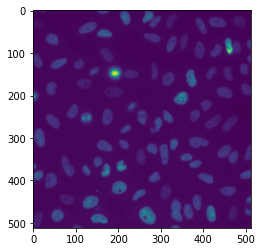

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(all_tracks[0].X[1][0])

In [66]:
all_tracks[0].appearances.shape

(11, 71, 168, 65, 64, 1)

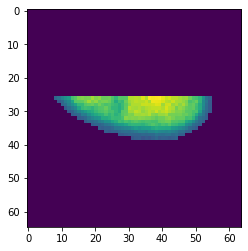

In [67]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][0][0])

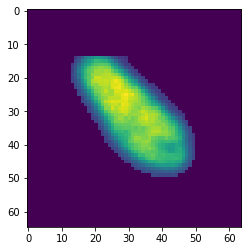

In [68]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][0][1])

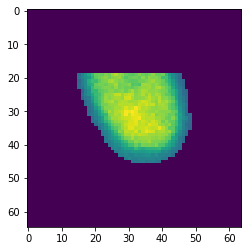

In [69]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][70][2])

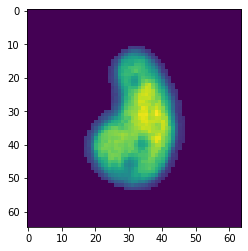

In [70]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[10][15][10])

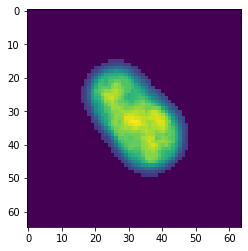

In [71]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[10][15][20])

In [72]:
%%time
from deepcell_tracking.utils import concat_tracks
track_info = concat_tracks(all_tracks)

CPU times: user 744 ms, sys: 992 ms, total: 1.74 s
Wall time: 1.73 s


In [73]:
for k, v in track_info.items():
    print(k, v.shape)

appearances (11, 71, 168, 65, 64, 1)
centroids (11, 71, 168, 2)
morphologies (11, 71, 168, 3)
adj_matrices (11, 71, 168, 168)
norm_adj_matrices (11, 71, 168, 168)
temporal_adj_matrices (11, 70, 168, 168, 3)


In [74]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

def prepare_dataset(track_info, batch_size=1, buffer_size=256,
                    seed=None, val_split=0.2):
    
    # Merge tracks along the batch axis
    appearances = track_info['appearances']
    
    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])
    
    # Normalize appearances
    appearances = norm(appearances)
    
    input_dict = {'appearances': appearances}
    
    output_dict = {'appearances_decoder': appearances}
    
    dataset = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)
    
    # split into train/val
    train_data, val_data = split_dataset(dataset, val_split)
    
    # batch the data
    train_data = train_data.repeat().batch(batch_size)
    val_data = val_data.repeat().batch(batch_size)
    
    # prefetch the data
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    
    return train_data, val_data

In [75]:
train_data, val_data = prepare_dataset(track_info,
                                       batch_size=1)

In [76]:
it = iter(train_data)

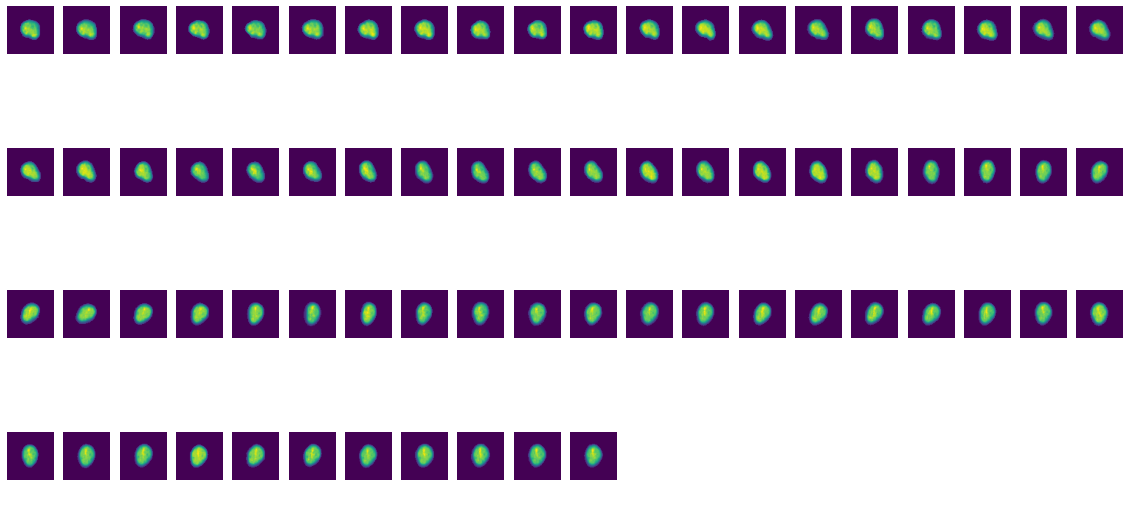

In [77]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

In [104]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, Conv3D, LSTM, Conv2DTranspose
from tensorflow.keras.layers import Input, Concatenate, InputLayer
from tensorflow.keras.layers import Add, Subtract, Dense, Reshape
from tensorflow.keras.layers import MaxPool3D, UpSampling3D
from tensorflow.keras.layers import Activation, Softmax
from tensorflow.keras.layers import BatchNormalization, Lambda
from tensorflow_addons.layers import InstanceNormalization


in_kwargs = {'axis':-1,
             'center': True,
             'scale': True,
             'beta_initializer': 'random_uniform',
             'gamma_initializer': 'random_uniform'}

def residual_block(input_tensor, n_filters=64):
    y = Conv3D(n_filters,
           (1, 3, 3),
           strides=1,
           padding='same')(input_tensor)
    y = InstanceNormalization(**in_kwargs)(y)
    y = Activation('relu')(y)
    
    y = Conv3D(n_filters,
           (1, 3, 3),
           strides=1,
           padding='same')(y)
    y = InstanceNormalization(**in_kwargs)(y)
    y = Activation('relu')(y)
    
    y = Add()([input_tensor, y])
    
    return y
    
class TrajectoryEncoder():   
    def __init__(self,
                 n_filters = 64,
                 encoder_dim=256,
                 embedding_dim=1024,
                 appearance_shape=(71,65,64,1)):
        
        self.n_filters = n_filters
        self.encoder_dim = encoder_dim
        self.embedding_dim = embedding_dim
        self.appearance_shape = appearance_shape
        
        # create encoder
        self.app_encoder = self.get_appearance_encoder()
        
        # create embedding
        self.embedding_model = self.get_embedding_model()
        
        # create decoder
        self.app_decoder = self.get_appearance_decoder()
        
        # create autoencoder
        self.autoencoder = self.get_autoencoder()
    
    def get_appearance_encoder(self):
        app_shape = tuple([None] + list(self.appearance_shape)[1:])
        inputs = Input(shape=app_shape, name='encoder_app_input')

        x = inputs
        print(x.shape)
        x = Conv3D(self.n_filters,
                       (1,3,3),
                       strides=1,
                       padding='same')(x)
        print(x.shape)
        
        for i in range(6): 
            x = residual_block(x, self.n_filters)
            x = residual_block(x, self.n_filters)

            x = Conv3D(self.n_filters, 
                       (1,2,2), 
                       strides=(1,2,2), 
                       padding='valid',
                       use_bias=False)(x)
            print(x.shape)
            
        x = Lambda(lambda t: tf.squeeze(t, axis=(2, 3)))(x)
        print(x.shape)
        x = Dense(self.encoder_dim, name='dense_aeout')(x)
        print(x.shape)
        x = Activation('relu', name='appearance_embedding')(x)
        print(x.shape)
        return Model(inputs=inputs, outputs=x, name='appearance_encoder')
        
    def get_embedding_model(self):
        encoded_shape = tuple([None, self.encoder_dim])
        inputs = Input(shape=encoded_shape, name='embedding_model_input')
        
        x = inputs
        x = Dense(self.embedding_dim)(x)
        x = Activation('relu', name='embedding')(x)
        return Model(inputs=inputs, outputs=x, name='embedding')
    
    def get_appearance_decoder(self):
        embedding_shape = tuple([None, self.embedding_dim])
        inputs = Input(shape=embedding_shape, name='encoder_app_input')

        x = inputs
        x = Lambda(lambda t: tf.expand_dims(t, axis=-2))(x)
        x = Lambda(lambda t: tf.expand_dims(t, axis=-2))(x)
        
        x = Conv3D(self.n_filters,
               (1,3,3),
               strides=1,
               padding='same')(x)
        
        for i in range(6): 
            x = residual_block(x, self.n_filters)
            x = residual_block(x, self.n_filters)
            x = UpSampling3D(size=(1, 2, 2))(x)
            
        x = Dense(1, name='appearance_reconstruction')(x)
        return Model(inputs=inputs, outputs=x, name='appearances_decoder')
        
    def get_autoencoder(self):
        app_input = Input(shape=self.appearance_shape, name='appearances')

        x = self.app_encoder(app_input)
        embedding = self.embedding_model(x)
        reconstruction = self.app_decoder(embedding)

        inputs = app_input
        outputs = [embedding, reconstruction]
        return Model(inputs=inputs, outputs=[embedding, reconstruction])

In [98]:
# For 32x32 image with loop of 5
TE = TrajectoryEncoder()

(None, None, 32, 32, 1)
(None, None, 32, 32, 64)
(None, None, 16, 16, 64)
(None, None, 8, 8, 64)
(None, None, 4, 4, 64)
(None, None, 2, 2, 64)
(None, None, 1, 1, 64)
(None, None, 64)
(None, None, 256)
(None, None, 256)


In [105]:
# For 65x64 image with loop of 6
TE = TrajectoryEncoder()

(None, None, 65, 64, 1)
(None, None, 65, 64, 64)
(None, None, 32, 32, 64)
(None, None, 16, 16, 64)
(None, None, 8, 8, 64)
(None, None, 4, 4, 64)
(None, None, 2, 2, 64)
(None, None, 1, 1, 64)
(None, None, 64)
(None, None, 256)
(None, None, 256)


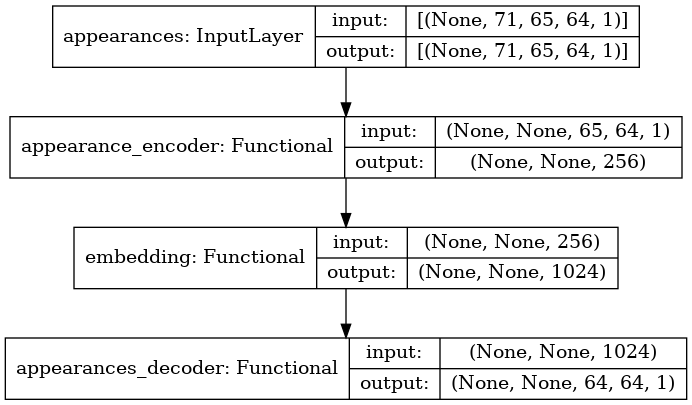

In [106]:
from tensorflow.keras.utils import plot_model
plot_model(TE.autoencoder, show_shapes=True)

In [107]:
def self_supervised_loss(y_true, y_pred):
    
    # Pair the current embedding with the future ground truth
    # so that we predict the future from the past
    
    current_reconstruction = y_pred
    gt = y_true
    
    loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    
    return loss

In [108]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

# Define optimizer
optimizer = RAdam(lr=1e-3, clipnorm=0.001)
losses = {'appearances_decoder': self_supervised_loss}
num_gpus = train_utils.count_gpus()
print('Training on {} GPUs'.format(num_gpus))

# Compile model
TE.autoencoder.compile(optimizer=optimizer, loss=losses)

# Train the model
model_path = '/data/models/app_pad_model'
steps_per_epoch = 2048
validation_steps = 100
n_epochs = 1

train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
]

loss_history = TE.autoencoder.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training on 1 GPUs


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    <ipython-input-107-d5ffa12f6bd2>:9 self_supervised_loss  *
        loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/losses.py:1215 mean_squared_error
        return backend.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_math_ops.py:10423 squared_difference
        "SquaredDifference", x=x, y=y, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:601 _create_op_internal
        compute_device)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:3565 _create_op_internal
        op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:2042 __init__
        control_input_ops, op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 64 and 65 for '{{node self_supervised_loss/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_5/appearances_decoder/appearance_reconstruction/BiasAdd, Cast)' with input shapes: [?,71,64,64,1], [?,71,65,64,1].


In [120]:
# Implementation to get 64x64 images (since images are 65x64 by correct implementation)

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import io
import json
import os
import re
import tarfile
import tempfile

import numpy as np
import math

from scipy.spatial.distance import cdist

from skimage.measure import regionprops
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import resize


def clean_up_annotations(y, uid=None, data_format='channels_last'):
    """Relabels every frame in the label matrix.
    Args:
        y (np.array): annotations to relabel sequentially.
        uid (int, optional): starting ID to begin labeling cells.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        np.array: Cleaned up annotations.
    """
    y = y.astype('int32')
    time_axis = 1 if data_format == 'channels_first' else 0
    num_frames = y.shape[time_axis]

    all_uniques = []
    for f in range(num_frames):
        cells = np.unique(y[:, f] if data_format == 'channels_first' else y[f])
        cells = np.delete(cells, np.where(cells == 0))
        all_uniques.append(cells)

    # The annotations need to be unique across all frames
    uid = sum(len(x) for x in all_uniques) + 1 if uid is None else uid
    for frame, unique_cells in zip(range(num_frames), all_uniques):
        y_frame = y[:, frame] if data_format == 'channels_first' else y[frame]
        y_frame_new = np.zeros(y_frame.shape)
        for cell_label in unique_cells:
            y_frame_new[y_frame == cell_label] = uid
            uid += 1
        if data_format == 'channels_first':
            y[:, frame] = y_frame_new
        else:
            y[frame] = y_frame_new
    return y


def count_pairs(y, same_probability=0.5, data_format='channels_last'):
    """Compute number of training samples needed to observe all cell pairs.
    Args:
        y (np.array): 5D tensor of cell labels.
        same_probability (float): liklihood that 2 cells are the same.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        int: the total pairs needed to sample to see all possible pairings.
    """
    total_pairs = 0
    zaxis = 2 if data_format == 'channels_first' else 1
    for b in range(y.shape[0]):
        # count the number of cells in each image of the batch
        cells_per_image = []
        for f in range(y.shape[zaxis]):
            if data_format == 'channels_first':
                num_cells = len(np.unique(y[b, :, f, :, :]))
            else:
                num_cells = len(np.unique(y[b, f, :, :, :]))
            cells_per_image.append(num_cells)

        # Since there are many more possible non-self pairings than there
        # are self pairings, we want to estimate the number of possible
        # non-self pairings and then multiply that number by two, since the
        # odds of getting a non-self pairing are 50%, to find out how many
        # pairs we would need to sample to (statistically speaking) observe
        # all possible cell-frame pairs. We're going to assume that the
        # average cell is present in every frame. This will lead to an
        # underestimate of the number of possible non-self pairings, but it
        # is unclear how significant the underestimate is.
        average_cells_per_frame = sum(cells_per_image) // y.shape[zaxis]
        non_self_cellframes = (average_cells_per_frame - 1) * y.shape[zaxis]
        non_self_pairings = non_self_cellframes * max(cells_per_image)

        # Multiply cell pairings by 2 since the
        # odds of getting a non-self pairing are 50%
        cell_pairings = non_self_pairings // same_probability
        # Add this batch cell-pairings to the total count
        total_pairs += cell_pairings
    return total_pairs


def load_trks(filename):
    """Load a trk/trks file.
    Args:
        filename (str): full path to the file including .trk/.trks.
    Returns:
        dict: A dictionary with raw, tracked, and lineage data.
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = io.BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = io.BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

        # trks.extractfile opens a file in bytes mode, json can't use bytes.
        _, file_extension = os.path.splitext(filename)

        if file_extension == '.trks':
            trk_data = trks.getmember('lineages.json')
            lineages = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            for i, tracks in enumerate(lineages):
                lineages[i] = {int(k): v for k, v in tracks.items()}

        elif file_extension == '.trk':
            trk_data = trks.getmember('lineage.json')
            lineage = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            lineages = []
            lineages.append({int(k): v for k, v in lineage.items()})

    return {'lineages': lineages, 'X': raw, 'y': tracked}


def trk_folder_to_trks(dirname, trks_filename):
    """Compiles a directory of trk files into one trks_file.
    Args:
        dirname (str): full path to the directory containing multiple trk files.
        trks_filename (str): desired filename (the name should end in .trks).
    """
    lineages = []
    raw = []
    tracked = []

    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    file_list = os.listdir(dirname)
    file_list_sorted = sorted(file_list, key=alphanum_key)

    for filename in file_list_sorted:
        trk = load_trks(os.path.join(dirname, filename))
        lineages.append(trk['lineages'][0])  # this is loading a single track
        raw.append(trk['X'])
        tracked.append(trk['y'])

    file_path = os.path.join(os.path.dirname(dirname), trks_filename)

    save_trks(file_path, lineages, raw, tracked)


def save_trks(filename, lineages, raw, tracked):
    """Saves raw, tracked, and lineage data into one trks_file.
    Args:
        filename (str): full path to the final trk files.
        lineages (dict): a list of dictionaries saved as a json.
        raw (np.array): raw images data.
        tracked (np.array): annotated image data.
    Raises:
        ValueError: filename does not end in ".trks".
    """
    if not str(filename).lower().endswith('.trks'):
        raise ValueError('filename must end with `.trks`. Found %s' % filename)

    with tarfile.open(filename, 'w:gz') as trks:
        with tempfile.NamedTemporaryFile('w', delete=False) as lineages_file:
            json.dump(lineages, lineages_file, indent=4)
            lineages_file.flush()
            lineages_file.close()
            trks.add(lineages_file.name, 'lineages.json')
            os.remove(lineages_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            raw_file.close()
            trks.add(raw_file.name, 'raw.npy')
            os.remove(raw_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as tracked_file:
            np.save(tracked_file, tracked)
            tracked_file.flush()
            tracked_file.close()
            trks.add(tracked_file.name, 'tracked.npy')
            os.remove(tracked_file.name)


def trks_stats(filename):
    """For a given trks_file, find the Number of cell tracks,
       the Number of frames per track, and the Number of divisions.
    Args:
        filename (str): full path to a trks file.
    Raises:
        ValueError: filename is not a .trk or .trks file.
    """
    ext = os.path.splitext(filename)[-1].lower()
    if ext not in {'.trks', '.trk'}:
        raise ValueError('`trks_stats` expects a .trk or .trks but found a ' +
                         str(ext))

    training_data = load_trks(filename)
    X = training_data['X']
    y = training_data['y']
    daughters = [{cell: fields['daughters']
                  for cell, fields in tracks.items()}
                 for tracks in training_data['lineages']]

    print('Dataset Statistics: ')
    print('Image data shape: ', X.shape)
    print('Number of lineages (should equal batch size): ',
          len(training_data['lineages']))

    # Calculate cell density
    frame_area = X.shape[2] * X.shape[3]

    avg_cells_in_frame = []
    for batch in range(y.shape[0]):
        num_cells_in_frame = []
        for frame in y[batch]:
            cells_in_frame = len(np.unique(frame)) - 1  # unique returns 0 (BKGD)
            num_cells_in_frame.append(cells_in_frame)
        avg_cells_in_frame.append(np.average(num_cells_in_frame))
    avg_cells_per_sq_pixel = np.average(avg_cells_in_frame) / frame_area

    # Calculate division information
    total_tracks = 0
    total_divisions = 0
    avg_frame_counts_in_batches = []
    for batch, daughter_batch in enumerate(daughters):
        num_tracks_in_batch = len(daughter_batch)
        num_div_in_batch = len([c for c in daughter_batch if daughter_batch[c]])
        total_tracks = total_tracks + num_tracks_in_batch
        total_divisions = total_divisions + num_div_in_batch
        frame_counts = []
        for cell_id in daughter_batch.keys():
            frame_count = 0
            for frame in y[batch]:
                cells_in_frame = np.unique(frame)
                if cell_id in cells_in_frame:
                    frame_count += 1
            frame_counts.append(frame_count)
        avg_frame_counts_in_batches.append(np.average(frame_counts))
    avg_num_frames_per_track = np.average(avg_frame_counts_in_batches)

    print('Total number of unique tracks (cells)      - ', total_tracks)
    print('Total number of divisions                  - ', total_divisions)
    print('Average cell density (cells/100 sq pixels) - ', avg_cells_per_sq_pixel * 100)
    print('Average number of frames per track         - ', int(avg_num_frames_per_track))


def get_max_cells(y):
    """Helper function for finding the maximum number of cells in a frame of a movie, across
    all frames of the movie. Can be used for batches/tracks interchangeably with frames/cells.
    Args:
        y (np.array): Annotated image data
    Returns:
        int: The maximum number of cells in any frame
    """
    max_cells = 0
    for frame in range(y.shape[0]):
        cells = np.unique(y[frame])
        n_cells = cells[cells != 0].shape[0]
        if n_cells > max_cells:
            max_cells = n_cells
    return max_cells


def normalize_adj_matrix(adj, epsilon=1e-5):
    """Normalize the adjacency matrix
    Args:
        adj (np.array): Adjacency matrix
        epsilon (float): Used to create the degree matrix
    Returns:
        np.array: Normalized adjacency matrix
    Raises:
        ValueError: If ``adj`` has a rank that is not 3 or 4.
    """
    input_rank = len(adj.shape)
    if input_rank not in {3, 4}:
        raise ValueError('Only 3 & 4 dim adjacency matrices are supported')

    if input_rank == 3:
        # temporarily include a batch dimension for consistent processing
        adj = np.expand_dims(adj, axis=0)

    normalized_adj = np.zeros(adj.shape, dtype='float32')

    for t in range(adj.shape[1]):
        adj_frame = adj[:, t]
        # create degree matrix
        degrees = np.sum(adj_frame, axis=1)
        for batch, degree in enumerate(degrees):
            degree = (degree + epsilon) ** -0.5
            degree_matrix = np.diagflat(degree)

            normalized = np.matmul(degree_matrix, adj_frame[batch])
            normalized = np.matmul(normalized, degree_matrix)
            normalized_adj[batch, t] = normalized

    if input_rank == 3:
        # remove batch axis
        normalized_adj = normalized_adj[0]

    return normalized_adj


def relabel_sequential_lineage(y, lineage):
    """Ensure the lineage information is sequentially labeled.
    Args:
        y (np.array): Annotated z-stack of image labels.
        lineage (dict): Lineage data for y.
    Returns:
        tuple(np.array, dict): The relabeled array and corrected lineage.
    """
    y_relabel, fw, _ = relabel_sequential(y)

    new_lineage = {}

    cell_ids = np.unique(y)
    cell_ids = cell_ids[cell_ids != 0]
    for cell_id in cell_ids:
        new_cell_id = fw[cell_id]

        new_lineage[new_cell_id] = {}

        # Fix label
        # TODO: label == track ID?
        new_lineage[new_cell_id]['label'] = new_cell_id

        # Fix parent
        parent = lineage[cell_id]['parent']
        new_parent = fw[parent] if parent is not None else parent
        new_lineage[new_cell_id]['parent'] = new_parent

        # Fix daughters
        daughters = lineage[cell_id]['daughters']
        new_lineage[new_cell_id]['daughters'] = [fw[d] for d in daughters]

        # Fix frames
        y_true = np.sum(y == cell_id, axis=(1, 2))
        y_index = np.where(y_true > 0)[0]
        new_lineage[new_cell_id]['frames'] = list(y_index)

    return y_relabel, new_lineage


def is_valid_lineage(lineage):
    """Check if a cell lineage of a single movie is valid.
    Daughter cells must exist in the frame after the parent's final frame.
    Args:
        lineage (dict): The cell lineages for a single movie.
    Returns:
        bool: Whether or not the lineage is valid.
    """
    for cell_lineage in lineage.values():
        # Get last frame of parent
        last_parent_frame = cell_lineage['frames'][-1]

        for daughter in cell_lineage['daughters']:
            # get first frame of daughter
            first_daughter_frame = lineage[daughter]['frames'][0]

            # Check that daughter's start frame is one larger than parent end frame
            if first_daughter_frame - last_parent_frame != 1:
                return False

    return True  # all cell lineages are valid!

def get_appearance_dimensions(X_arr, y_arr):
    """Get the dimensions of the appearance images.
    Args:
        X_arr (np.array): a 5D numpy array of raw data of shape (b, f, x, y, c).
        y_arr (np.array): a 5D numpy array of integer labels of shape (b, f, x, y, 1).
    Returns:
        tuple: A tuple of dimensions of shape (2)."""
    app_rows = 0
    app_cols = 0
    
    n_batches = X_arr.shape[0]
    n_frames = X_arr.shape[1]
    
    for batch in range(n_batches):
        for frame in range(n_frames):
            y = y_arr[batch, frame]
            props = regionprops(y[..., 0], cache=False)
            for prop in props:
                # Get appearance dimensions
                minr, minc, maxr, maxc = prop.bbox
                row = maxr - minr
                col = maxc - minc
                if row > app_rows:
                    app_rows = row
                if col > app_cols:
                    app_cols = col

    return app_rows, app_cols


def get_image_features(X, y, app_rows, app_cols, appearance_dim=64):
    """Return features for every object in the array.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        dict: A dictionary of feature names to np.arrays of shape
            (n, c) or (n, x, y, c) where n is the number of objects.
    """

    # each feature will be ordered based on the label.
    # labels are also stored and can be fetched by index.
    num_labels = len(np.unique(y)) - 1
    labels = np.zeros((num_labels,), dtype='int32')
    centroids = np.zeros((num_labels, 2), dtype='float32')
    morphologies = np.zeros((num_labels, 3), dtype='float32')
    
    appearance_dim = int(appearance_dim)

    appearances = np.zeros((num_labels, appearance_dim,
                            appearance_dim, X.shape[-1]), dtype='float32')

    # iterate over all objects in y
    props = regionprops(y[..., 0], cache=False)
    for i, prop in enumerate(props):
        # Get label
        labels[i] = prop.label

        # Get centroid
        centroid = np.array(prop.centroid)
        centroids[i] = centroid

        # Get morphology
        morphology = np.array([
            prop.area,
            prop.perimeter,
            prop.eccentricity
        ])
        morphologies[i] = morphology

        # Get appearance
        minr, minc, maxr, maxc = prop.bbox

        rows = maxr - minr
        cols = maxc - minc

        centr = app_rows / 2
        centc = app_cols / 2

        lowr = math.floor(centr - rows / 2)
        highr = math.floor(centr + rows / 2)
        lowc = math.floor(centc - cols / 2)
        highc = math.floor(centc + cols / 2)

        appearance = np.zeros((app_rows, app_cols, X.shape[-1]), dtype='float32')

        label = prop.label
        for r in range(lowr, highr):
            for c in range(lowc, highc):
                for n in range(X.shape[-1]):
                    pixel = X[minr + (r - lowr), minc + (c - lowc), n]
                    label_pixel = y[minr + (r - lowr), minc + (c - lowc), n]
                    
                    if label_pixel == label:
                        appearance[r, c, n] = pixel
                    else:
                        appearance[r, c, n] = 0
                        
        resize_shape = (appearance_dim, appearance_dim)
        appearance = resize(appearance, resize_shape)
        
        appearances[i] = appearance  

    # Get adjacency matrix
    # distance = cdist(centroids, centroids, metric='euclidean') < distance_threshold
    # adj_matrix = distance.astype('float32')

    return {
        'appearances': appearances,
        'centroids': centroids,
        'labels': labels,
        'morphologies': morphologies,
        # 'adj_matrix': adj_matrix,
    }


def concat_tracks(tracks):
    """Join an iterable of Track objects into a single dictionary of features.
    Args:
        tracks (iterable): Iterable of tracks.
    Returns:
        dict: A dictionary of tracked features.
    Raises:
        TypeError: ``tracks`` is not iterable.
    """
    try:
        list(tracks)  # check if iterable
    except TypeError:
        raise TypeError('concatenate_tracks requires an iterable input.')

    def get_array_of_max_shape(lst):
        # find max dimensions of all arrs in lst.
        shape = None
        size = 0
        for arr in lst:
            if shape is None:
                shape = [0] * len(arr.shape[1:])
            for i, dim in enumerate(arr.shape[1:]):
                if dim > shape[i]:
                    shape[i] = dim
            size += arr.shape[0]
        # add batch dimension
        shape = [size] + shape
        return np.zeros(shape, dtype='float32')

    # insert small array into larger array
    # https://stackoverflow.com/a/50692782
    def paste_slices(tup):
        pos, w, max_w = tup
        wall_min = max(pos, 0)
        wall_max = min(pos + w, max_w)
        block_min = -min(pos, 0)
        block_max = max_w - max(pos + w, max_w)
        block_max = block_max if block_max != 0 else None
        return slice(wall_min, wall_max), slice(block_min, block_max)

    def paste(wall, block, loc):
        loc_zip = zip(loc, block.shape, wall.shape)
        wall_slices, block_slices = zip(*map(paste_slices, loc_zip))
        wall[wall_slices] = block[block_slices]

    # TODO: these keys must match the Track attributes.
    track_info = {
        'appearances': get_array_of_max_shape((t.appearances for t in tracks)),
        'centroids': get_array_of_max_shape((t.centroids for t in tracks)),
        'morphologies': get_array_of_max_shape((t.morphologies for t in tracks)),
        'adj_matrices': get_array_of_max_shape((t.adj_matrices for t in tracks)),
        'norm_adj_matrices': get_array_of_max_shape(
            (t.norm_adj_matrices for t in tracks)),
        'temporal_adj_matrices': get_array_of_max_shape(
            (t.temporal_adj_matrices for t in tracks))
    }

    for track in tracks:
        for k in track_info:
            feature = getattr(track, k)
            paste(track_info[k], feature, (0,) * len(feature.shape))

    return track_info


class Track(object):  # pylint: disable=useless-object-inheritance

    def __init__(self, path=None, tracked_data=None,
                 appearance_dim=64, distance_threshold=64):
        if tracked_data:
            training_data = tracked_data
        elif path:
            training_data = load_trks(path)
        else:
            raise ValueError('One of `tracked_data` or `path` is required')
        self.X = training_data['X'].astype('float32')
        self.y = training_data['y'].astype('int32')
        self.lineages = training_data['lineages']
        self.appearance_dim = appearance_dim
        self.distance_threshold = distance_threshold

        # Correct lineages
        self._correct_lineages()

        # Remove bad batches
        self._remove_invalid_batches()

        # Create feature dictionaries
        features_dict = self._get_features()
        self.appearances = features_dict['appearances']
        self.morphologies = features_dict['morphologies']
        self.centroids = features_dict['centroids']
        self.adj_matrices = features_dict['adj_matrix']
        self.norm_adj_matrices = normalize_adj_matrix(self.adj_matrices)
        self.temporal_adj_matrices = features_dict['temporal_adj_matrix']
        self.mask = features_dict['mask']
        self.track_length = features_dict['track_length']

    def _correct_lineages(self):
        """Ensure sequential labels for all batches"""
        new_lineages = {}
        for batch in range(self.y.shape[0]):

            y_relabel, new_lineage = relabel_sequential_lineage(
                self.y[batch], self.lineages[batch])

            new_lineages[batch] = new_lineage
            self.y[batch] = y_relabel

        self.lineages = new_lineages

    def _remove_invalid_batches(self):
        """Remove all movies and lineages that are invalid.
        All batches with a daughter cell starting in a frame
        other than the parent's final frame will be dropped.
        """
        bad_batches = set()

        for batch in range(self.y.shape[0]):
            if not is_valid_lineage(self.lineages[batch]):
                bad_batches.add(batch)

        new_X = []
        new_y = []
        new_lineages = []
        for batch in range(self.X.shape[0]):
            if batch not in bad_batches:
                new_X.append(self.X[batch])
                new_y.append(self.y[batch])
                new_lineages.append(self.lineages[batch])

        self.X = np.stack(new_X, axis=0)
        self.y = np.stack(new_y, axis=0)
        self.lineages = new_lineages

    def _get_features(self):
        """
        Extract the relevant features from the label movie
        Appearance, morphologies, centroids, and adjacency matrices
        """
        max_tracks = get_max_cells(self.y)
        n_batches = self.X.shape[0]
        n_frames = self.X.shape[1]
        n_channels = self.X.shape[-1]

        batch_shape = (n_batches, n_frames, max_tracks)
        
        app_rows, app_cols = get_appearance_dimensions(self.X, self.y)
        app_rows = int(app_rows)
        app_cols = int(app_cols)

        appearance_shape = (self.appearance_dim, self.appearance_dim, n_channels)

        appearances = np.zeros(batch_shape + appearance_shape, dtype='float32')

        morphologies = np.zeros(batch_shape + (3,), dtype='float32')

        centroids = np.zeros(batch_shape + (2,), dtype='float32')

        adj_matrix = np.zeros(batch_shape + (max_tracks,), dtype='float32')

        temporal_adj_matrix = np.zeros((n_batches,
                                        n_frames - 1,
                                        max_tracks,
                                        max_tracks,
                                        3), dtype='float32')

        mask = np.zeros(batch_shape, dtype='float32')

        track_length = np.zeros((n_batches, max_tracks, 2), dtype='int32')

        for batch in range(n_batches):
            for frame in range(n_frames):

                frame_features = get_image_features(
                    self.X[batch, frame], self.y[batch, frame], app_rows, app_cols,
                    appearance_dim=self.appearance_dim)

                track_ids = frame_features['labels'] - 1
                centroids[batch, frame, track_ids] = frame_features['centroids']
                morphologies[batch, frame, track_ids] = frame_features['morphologies']
                appearances[batch, frame, track_ids] = frame_features['appearances']
                mask[batch, frame, track_ids] = 1

                # Get adjacency matrix, cannot filter on track ids.
                cent = centroids[batch, frame]
                distance = cdist(cent, cent, metric='euclidean')
                distance = distance < self.distance_threshold
                adj_matrix[batch, frame] = distance.astype(np.float32)

            # Get track length and temporal adjacency matrix
            for label in self.lineages[batch]:
                # Get track length
                start_frame = self.lineages[batch][label]['frames'][0]
                end_frame = self.lineages[batch][label]['frames'][-1]

                track_id = label - 1
                track_length[batch, track_id, 0] = start_frame
                track_length[batch, track_id, 1] = end_frame

                # Get temporal adjacency matrix
                frames = self.lineages[batch][label]['frames']

                # Assign same
                for f0, f1 in zip(frames[0:-1], frames[1:]):
                    if f1 - f0 == 1:
                        temporal_adj_matrix[batch, f0, track_id, track_id, 0] = 1

                # Assign daughter
                # WARNING: This wont work if there's a time gap between mother
                # cell disappearing and daughter cells appearing
                last_frame = frames[-1]
                daughters = self.lineages[batch][label]['daughters']
                for daughter in daughters:
                    daughter_id = daughter - 1
                    temporal_adj_matrix[batch, last_frame, track_id, daughter_id, 2] = 1

            # Assign different
            same_prob = temporal_adj_matrix[batch, ..., 0]
            daughter_prob = temporal_adj_matrix[batch, ..., 2]
            temporal_adj_matrix[batch, ..., 1] = 1 - same_prob - daughter_prob

            # Identify padding
            for i in range(temporal_adj_matrix.shape[2]):
                # index + 1 is the cell label
                if i + 1 not in self.lineages[batch]:
                    temporal_adj_matrix[batch, :, i] = -1
                    temporal_adj_matrix[batch, :, :, i] = -1

        feature_dict = {}
        feature_dict['adj_matrix'] = adj_matrix
        feature_dict['appearances'] = appearances
        feature_dict['morphologies'] = morphologies
        feature_dict['centroids'] = centroids
        feature_dict['temporal_adj_matrix'] = temporal_adj_matrix
        feature_dict['mask'] = mask
        feature_dict['track_length'] = track_length

        return feature_dict

In [121]:
%%time
path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

CPU times: user 463 ms, sys: 897 ms, total: 1.36 s
Wall time: 1.36 s


In [122]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 6min 57s, sys: 7.09 s, total: 7min 4s
Wall time: 6min 51s


In [123]:
len(all_tracks)

1

In [124]:
all_tracks[0].X.shape

(11, 71, 512, 512, 1)

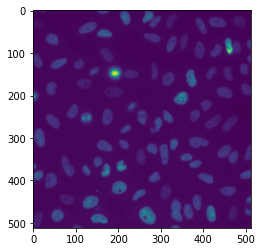

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(all_tracks[0].X[1][0])

In [126]:
all_tracks[0].appearances.shape

(11, 71, 168, 64, 64, 1)

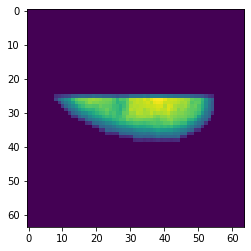

In [127]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][0][0])

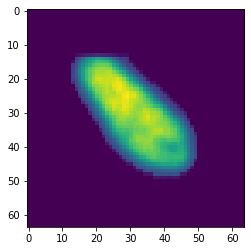

In [128]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][0][1])

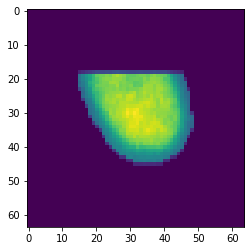

In [129]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[0][70][2])

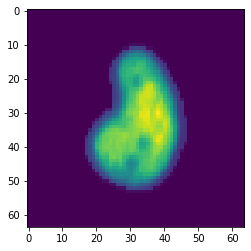

In [130]:
fig, ax = plt.subplots()
ax.imshow(all_tracks[0].appearances[10][15][10])

In [131]:
%%time
from deepcell_tracking.utils import concat_tracks
track_info = concat_tracks(all_tracks)

CPU times: user 784 ms, sys: 914 ms, total: 1.7 s
Wall time: 1.7 s


In [132]:
for k, v in track_info.items():
    print(k, v.shape)

appearances (11, 71, 168, 64, 64, 1)
centroids (11, 71, 168, 2)
morphologies (11, 71, 168, 3)
adj_matrices (11, 71, 168, 168)
norm_adj_matrices (11, 71, 168, 168)
temporal_adj_matrices (11, 70, 168, 168, 3)


In [133]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

def prepare_dataset(track_info, batch_size=1, buffer_size=256,
                    seed=None, val_split=0.2):
    
    # Merge tracks along the batch axis
    appearances = track_info['appearances']
    
    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])
    
    # Normalize appearances
    appearances = norm(appearances)
    
    input_dict = {'appearances': appearances}
    
    output_dict = {'appearances_decoder': appearances}
    
    dataset = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)
    
    # split into train/val
    train_data, val_data = split_dataset(dataset, val_split)
    
    # batch the data
    train_data = train_data.repeat().batch(batch_size)
    val_data = val_data.repeat().batch(batch_size)
    
    # prefetch the data
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    
    return train_data, val_data

In [134]:
train_data, val_data = prepare_dataset(track_info,
                                       batch_size=1)

In [135]:
it = iter(train_data)

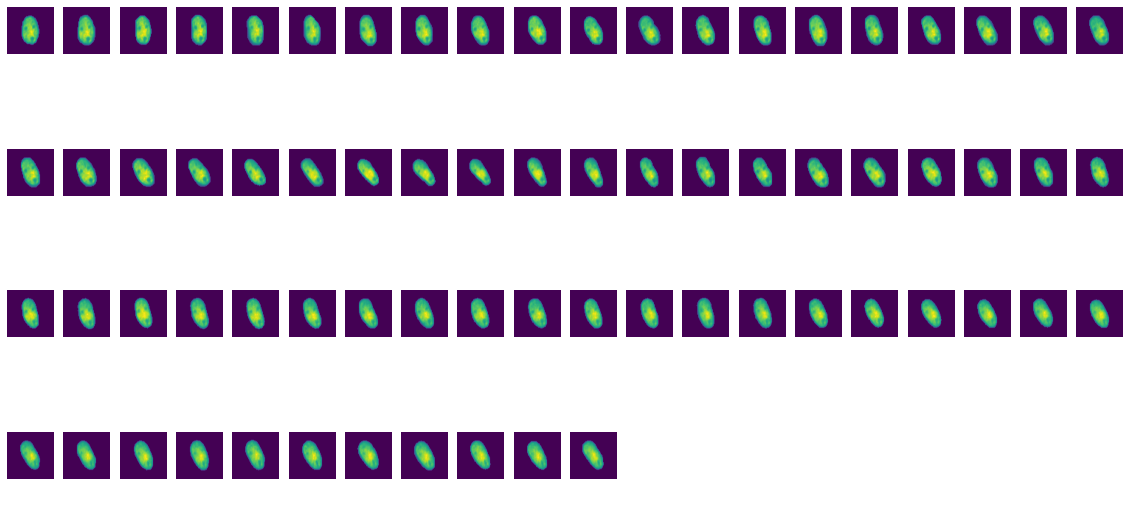

In [136]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

In [140]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, Conv3D, LSTM, Conv2DTranspose
from tensorflow.keras.layers import Input, Concatenate, InputLayer
from tensorflow.keras.layers import Add, Subtract, Dense, Reshape
from tensorflow.keras.layers import MaxPool3D, UpSampling3D
from tensorflow.keras.layers import Activation, Softmax
from tensorflow.keras.layers import BatchNormalization, Lambda
from tensorflow_addons.layers import InstanceNormalization


in_kwargs = {'axis':-1,
             'center': True,
             'scale': True,
             'beta_initializer': 'random_uniform',
             'gamma_initializer': 'random_uniform'}

def residual_block(input_tensor, n_filters=64):
    y = Conv3D(n_filters,
           (1, 3, 3),
           strides=1,
           padding='same')(input_tensor)
    y = InstanceNormalization(**in_kwargs)(y)
    y = Activation('relu')(y)
    
    y = Conv3D(n_filters,
           (1, 3, 3),
           strides=1,
           padding='same')(y)
    y = InstanceNormalization(**in_kwargs)(y)
    y = Activation('relu')(y)
    
    y = Add()([input_tensor, y])
    
    return y
    
class TrajectoryEncoder():   
    def __init__(self,
                 n_filters = 64,
                 encoder_dim=256,
                 embedding_dim=1024,
                 appearance_shape=(71,64,64,1)):
        
        self.n_filters = n_filters
        self.encoder_dim = encoder_dim
        self.embedding_dim = embedding_dim
        self.appearance_shape = appearance_shape
        
        # create encoder
        self.app_encoder = self.get_appearance_encoder()
        
        # create embedding
        self.embedding_model = self.get_embedding_model()
        
        # create decoder
        self.app_decoder = self.get_appearance_decoder()
        
        # create autoencoder
        self.autoencoder = self.get_autoencoder()
    
    def get_appearance_encoder(self):
        app_shape = tuple([None] + list(self.appearance_shape)[1:])
        inputs = Input(shape=app_shape, name='encoder_app_input')

        x = inputs
        print(x.shape)
        x = Conv3D(self.n_filters,
                       (1,3,3),
                       strides=1,
                       padding='same')(x)
        print(x.shape)
        
        for i in range(6): 
            x = residual_block(x, self.n_filters)
            x = residual_block(x, self.n_filters)

            x = Conv3D(self.n_filters, 
                       (1,2,2), 
                       strides=(1,2,2), 
                       padding='valid',
                       use_bias=False)(x)
            print(x.shape)
            
        x = Lambda(lambda t: tf.squeeze(t, axis=(2, 3)))(x)
        print(x.shape)
        x = Dense(self.encoder_dim, name='dense_aeout')(x)
        print(x.shape)
        x = Activation('relu', name='appearance_embedding')(x)
        print(x.shape)
        return Model(inputs=inputs, outputs=x, name='appearance_encoder')
        
    def get_embedding_model(self):
        encoded_shape = tuple([None, self.encoder_dim])
        inputs = Input(shape=encoded_shape, name='embedding_model_input')
        
        x = inputs
        x = Dense(self.embedding_dim)(x)
        x = Activation('relu', name='embedding')(x)
        return Model(inputs=inputs, outputs=x, name='embedding')
    
    def get_appearance_decoder(self):
        embedding_shape = tuple([None, self.embedding_dim])
        inputs = Input(shape=embedding_shape, name='encoder_app_input')

        x = inputs
        x = Lambda(lambda t: tf.expand_dims(t, axis=-2))(x)
        x = Lambda(lambda t: tf.expand_dims(t, axis=-2))(x)
        
        x = Conv3D(self.n_filters,
               (1,3,3),
               strides=1,
               padding='same')(x)
        
        for i in range(6): 
            x = residual_block(x, self.n_filters)
            x = residual_block(x, self.n_filters)
            x = UpSampling3D(size=(1, 2, 2))(x)
            
        x = Dense(1, name='appearance_reconstruction')(x)
        return Model(inputs=inputs, outputs=x, name='appearances_decoder')
        
    def get_autoencoder(self):
        app_input = Input(shape=self.appearance_shape, name='appearances')

        x = self.app_encoder(app_input)
        embedding = self.embedding_model(x)
        reconstruction = self.app_decoder(embedding)

        inputs = app_input
        outputs = [embedding, reconstruction]
        return Model(inputs=inputs, outputs=[embedding, reconstruction])

In [141]:
# For 65x64 image with loop of 6
TE = TrajectoryEncoder()

(None, None, 64, 64, 1)
(None, None, 64, 64, 64)
(None, None, 32, 32, 64)
(None, None, 16, 16, 64)
(None, None, 8, 8, 64)
(None, None, 4, 4, 64)
(None, None, 2, 2, 64)
(None, None, 1, 1, 64)
(None, None, 64)
(None, None, 256)
(None, None, 256)


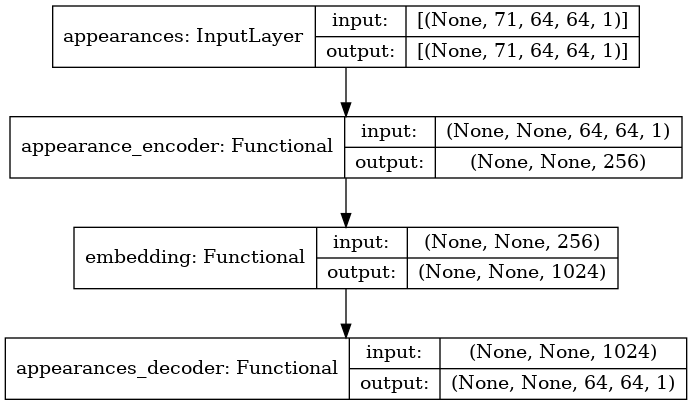

In [142]:
from tensorflow.keras.utils import plot_model
plot_model(TE.autoencoder, show_shapes=True)

In [143]:
def self_supervised_loss(y_true, y_pred):
    
    # Pair the current embedding with the future ground truth
    # so that we predict the future from the past
    
    current_reconstruction = y_pred
    gt = y_true
    
    loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    
    return loss

In [144]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

# Define optimizer
optimizer = RAdam(lr=1e-3, clipnorm=0.001)
losses = {'appearances_decoder': self_supervised_loss}
num_gpus = train_utils.count_gpus()
print('Training on {} GPUs'.format(num_gpus))

# Compile model
TE.autoencoder.compile(optimizer=optimizer, loss=losses)

# Train the model
model_path = '/data/models/app_pad_model'
steps_per_epoch = 2048
validation_steps = 100
n_epochs = 1

train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
]

loss_history = TE.autoencoder.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training on 1 GPUs
2048/2048 [==============================] - 705s 315ms/step - loss: 0.0069 - appearances_decoder_loss: 0.0069 - val_loss: 0.0047 - val_appearances_decoder_loss: 0.0047

Epoch 00001: val_loss improved from inf to 0.00468, saving model to /data/models/app_pad_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/app_pad_model/assets


INFO:tensorflow:Assets written to: /data/models/app_pad_model/assets


In [145]:
it = iter(train_data)

In [150]:
nxt = it.next()
inputs = nxt[0]['appearances']

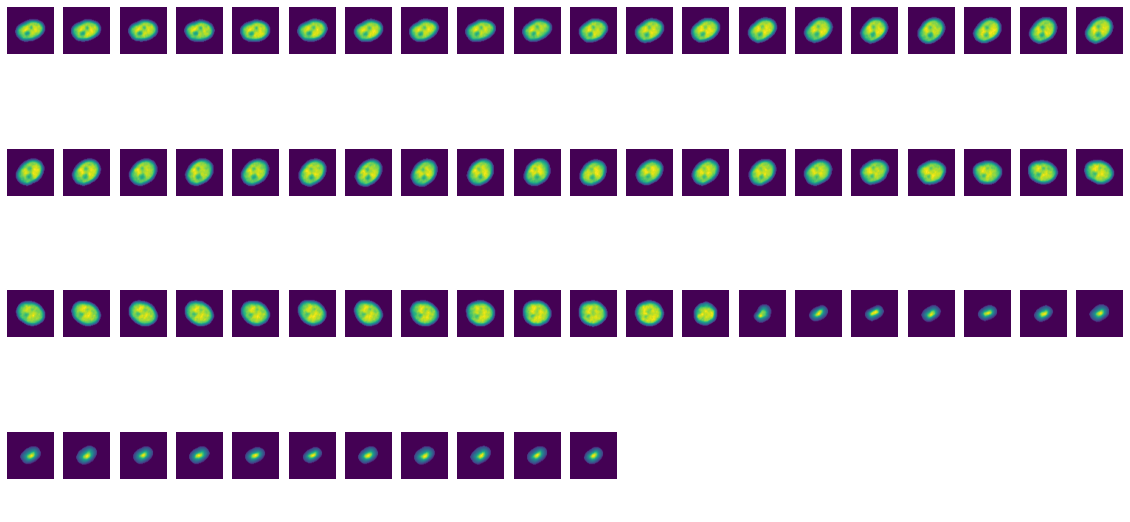

In [151]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
for j in range(71):
    axes.flatten()[j].imshow(inputs[0,j])
    axes.flatten()[j].set_axis_off()

In [152]:
app_encoded = TE.app_encoder(inputs)
embedding = TE.embedding_model(app_encoded)
reconstruction = TE.app_decoder(embedding)

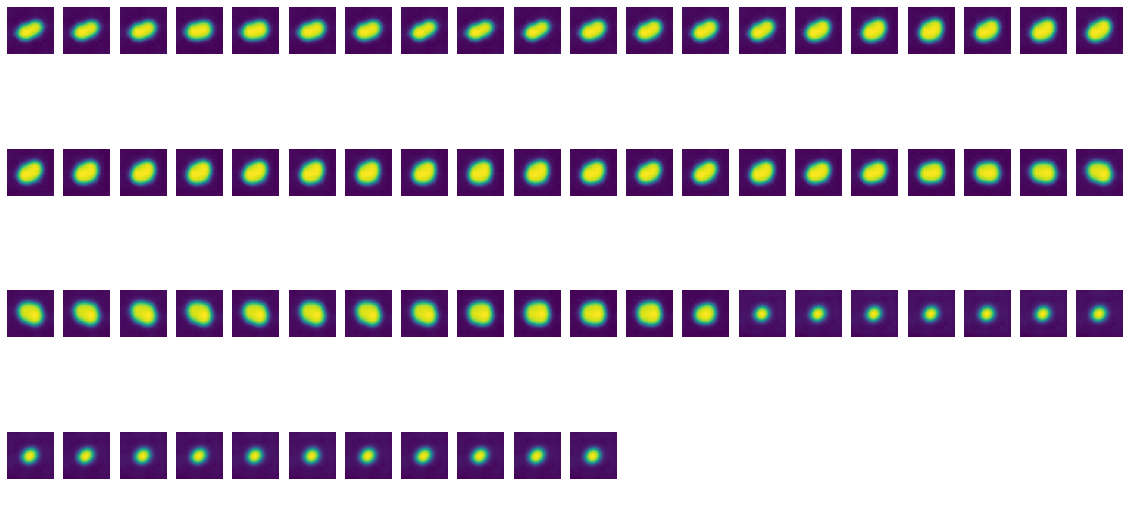

In [153]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
for j in range(71):
    axes.flatten()[j].imshow(reconstruction[0,j])
    axes.flatten()[j].set_axis_off()

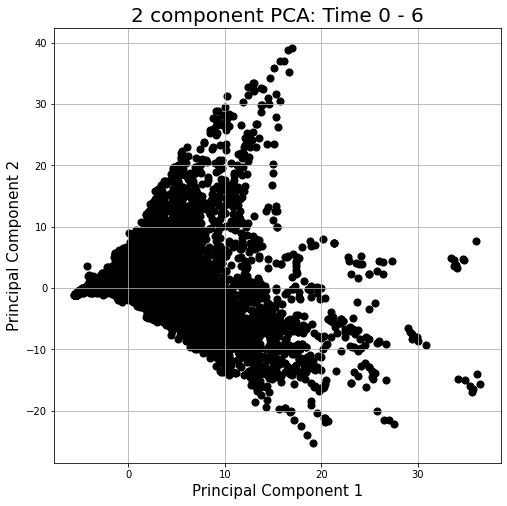

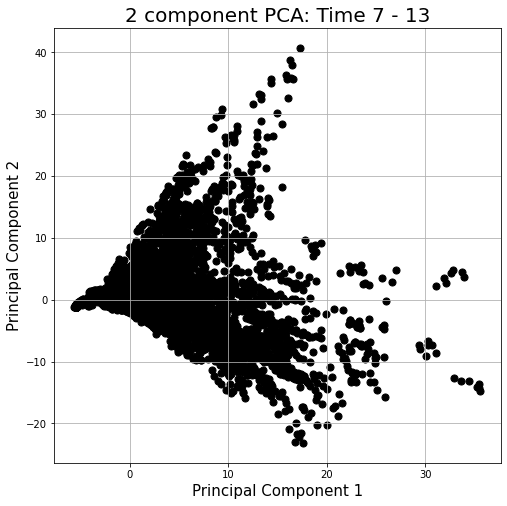

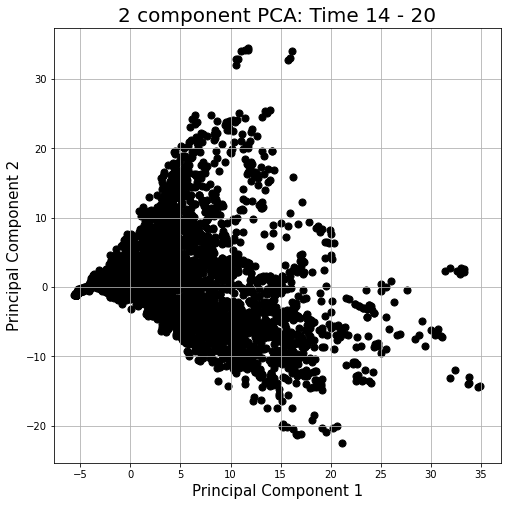

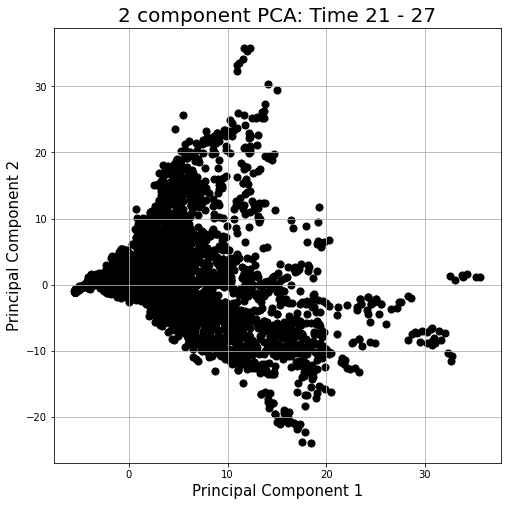

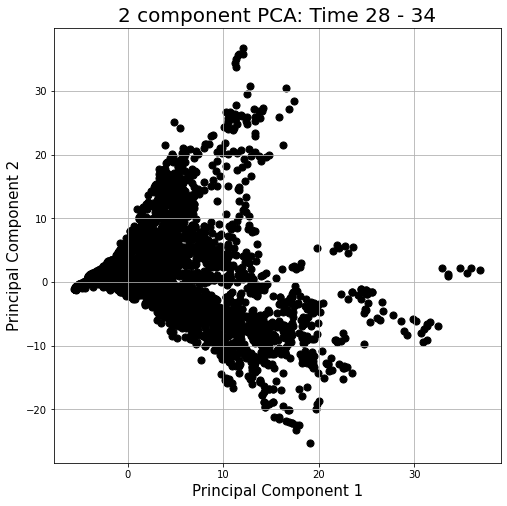

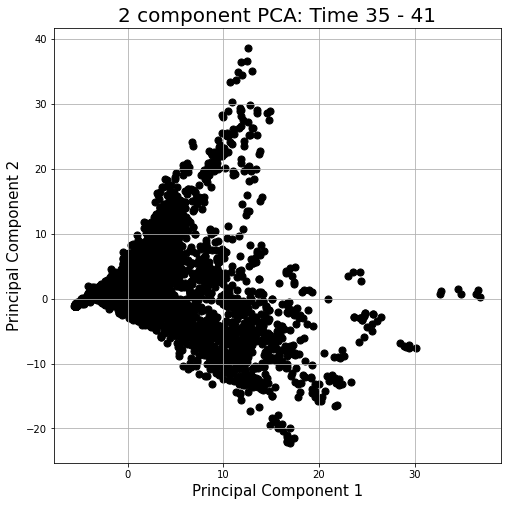

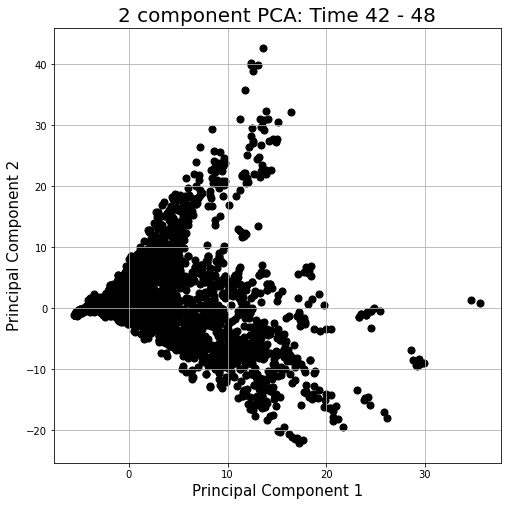

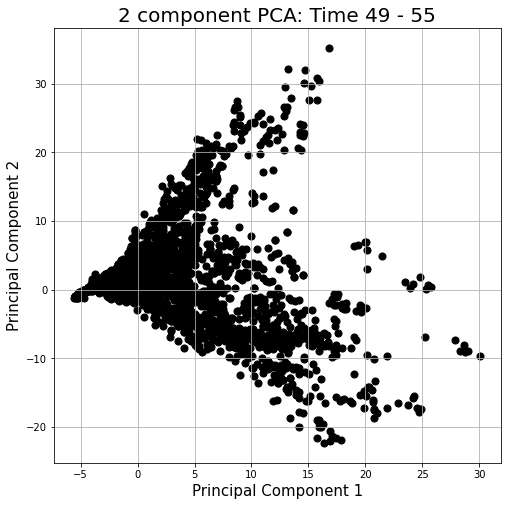

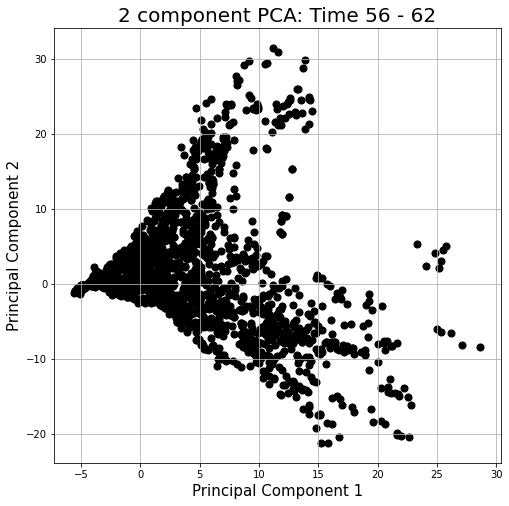

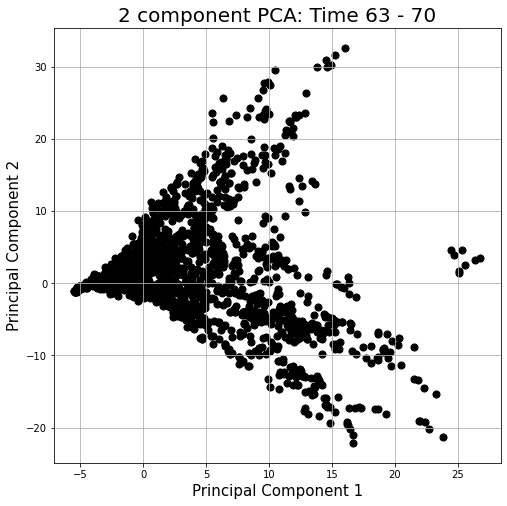

In [159]:
import pandas as pd

def get_temp_embeddings_df():
    it = iter(train_data)

    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    num_cells = shape[0] * shape[2]

    temp_embeddings_lst = []

    for cell in range(num_cells):
        batch = cell // shape[2]
        pos = cell - shape[2] * (cell // shape[2])
        first_frame = 0
        last_frame = 0
        centroids_shape = track_info['centroids'].shape
        for frame in range(centroids_shape[1]):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                first_frame = frame
                break
        for frame in range(centroids_shape[1] - 1, -1, -1):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                last_frame = frame
                break
        
        nxt = it.next()
        inputs = nxt[0]['appearances']
        app_encoded = TE.app_encoder(inputs)
        embeddings = TE.embedding_model(app_encoded)
        for frame in range(first_frame, last_frame + 1):
            # append time number to embedding
            time = frame - first_frame
            temp_embeddings_lst.append(np.append(embeddings[0][frame].numpy().astype('float32'), time))
            
    cols = [idx for idx in range(TE.embedding_dim)]
    cols.append('Time')
    temp_embeddings_df = pd.DataFrame(temp_embeddings_lst, columns=cols)
    
    return temp_embeddings_df

from sklearn.preprocessing import StandardScaler

def standardize_embeddings():
    temp_embeddings_df = get_temp_embeddings_df()
    
    features = [idx for idx in range(TE.embedding_dim)]
    embeddings = temp_embeddings_df.loc[:, features].values
    std_embeddings = StandardScaler().fit_transform(embeddings)
    
    std_embeddings_df = pd.DataFrame(std_embeddings)
    
    return std_embeddings_df

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

def project_embeddings():
    std_embeddings_df = standardize_embeddings()
    
    principal_components = pca.fit_transform(std_embeddings_df)
    principal_df = pd.DataFrame(data = principal_components, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

temp_embeddings_df = get_temp_embeddings_df()
temp_embeddings_pca_df = project_embeddings()

import math

shape = track_info['appearances'].shape

for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()
    plt.savefig('pad_time_embeddings_sections/pad_time_embeddings_pca_' + str(time_init) + '_' + str(time_final) + '.jpg')

In [161]:
cols = [idx for idx in range(TE.embedding_dim)]
cols.append('Frame')
temp_embeddings_df.to_csv('/data/pad_temp_embeddings.csv', header=cols)

In [162]:
cols = ['component 1', 'component 2', 'Frame']
temp_embeddings_pca_df.to_csv('/data/pad_temp_embeddings_pca.csv', header=cols)

In [184]:
# Try LSTM layer in place of Dense for embeddings
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, Conv3D, LSTM, Conv2DTranspose
from tensorflow.keras.layers import Input, Concatenate, InputLayer
from tensorflow.keras.layers import Add, Subtract, Dense, Reshape
from tensorflow.keras.layers import MaxPool3D, UpSampling3D
from tensorflow.keras.layers import Activation, Softmax
from tensorflow.keras.layers import BatchNormalization, Lambda
from tensorflow_addons.layers import InstanceNormalization


in_kwargs = {'axis':-1,
             'center': True,
             'scale': True,
             'beta_initializer': 'random_uniform',
             'gamma_initializer': 'random_uniform'}

def residual_block(input_tensor, n_filters=64):
    y = Conv3D(n_filters,
           (1, 3, 3),
           strides=1,
           padding='same')(input_tensor)
    y = InstanceNormalization(**in_kwargs)(y)
    y = Activation('relu')(y)
    
    y = Conv3D(n_filters,
           (1, 3, 3),
           strides=1,
           padding='same')(y)
    y = InstanceNormalization(**in_kwargs)(y)
    y = Activation('relu')(y)
    
    y = Add()([input_tensor, y])
    
    return y
    
class TrajectoryEncoder():   
    def __init__(self,
                 n_filters = 64,
                 encoder_dim=256,
                 embedding_dim=1024,
                 appearance_shape=(71,64,64,1)):
        
        self.n_filters = n_filters
        self.encoder_dim = encoder_dim
        self.embedding_dim = embedding_dim
        self.appearance_shape = appearance_shape
        
        # create encoder
        self.app_encoder = self.get_appearance_encoder()
        
        # create embedding
        self.embedding_model = self.get_embedding_model()
        
        # create decoder
        self.app_decoder = self.get_appearance_decoder()
        
        # create autoencoder
        self.autoencoder = self.get_autoencoder()
    
    def get_appearance_encoder(self):
        app_shape = tuple([None] + list(self.appearance_shape)[1:])
        inputs = Input(shape=app_shape, name='encoder_app_input')

        x = inputs
        print(x.shape)
        x = Conv3D(self.n_filters,
                       (1,3,3),
                       strides=1,
                       padding='same')(x)
        print(x.shape)
        
        for i in range(6): 
            x = residual_block(x, self.n_filters)
            x = residual_block(x, self.n_filters)

            x = Conv3D(self.n_filters, 
                       (1,2,2), 
                       strides=(1,2,2), 
                       padding='valid',
                       use_bias=False)(x)
            print(x.shape)
            
        x = Lambda(lambda t: tf.squeeze(t, axis=(2, 3)))(x)
        print(x.shape)
        x = Dense(self.encoder_dim, name='dense_aeout')(x)
        print(x.shape)
        x = Activation('relu', name='appearance_embedding')(x)
        print(x.shape)
        return Model(inputs=inputs, outputs=x, name='appearance_encoder')
        
    def get_embedding_model(self):
        encoded_shape = tuple([None, self.encoder_dim])
        inputs = Input(shape=encoded_shape, name='embedding_model_input')
        
        x = inputs
        x = LSTM(self.embedding_dim, return_sequences=True)(x)
        x = Activation('relu', name='embedding')(x)
        return Model(inputs=inputs, outputs=x, name='embedding')
    
    def get_appearance_decoder(self):
        embedding_shape = tuple([None, self.embedding_dim])
        inputs = Input(shape=embedding_shape, name='encoder_app_input')

        x = inputs
        x = Lambda(lambda t: tf.expand_dims(t, axis=-2))(x)
        x = Lambda(lambda t: tf.expand_dims(t, axis=-2))(x)
        
        x = Conv3D(self.n_filters,
               (1,3,3),
               strides=1,
               padding='same')(x)
        
        for i in range(6): 
            x = residual_block(x, self.n_filters)
            x = residual_block(x, self.n_filters)
            x = UpSampling3D(size=(1, 2, 2))(x)
            
        x = Dense(1, name='appearance_reconstruction')(x)
        return Model(inputs=inputs, outputs=x, name='appearances_decoder')
        
    def get_autoencoder(self):
        app_input = Input(shape=self.appearance_shape, name='appearances')

        x = self.app_encoder(app_input)
        embedding = self.embedding_model(x)
        reconstruction = self.app_decoder(embedding)

        inputs = app_input
        outputs = [embedding, reconstruction]
        return Model(inputs=inputs, outputs=[embedding, reconstruction])

In [185]:
# For 65x64 image with loop of 6
TE = TrajectoryEncoder()

(None, None, 64, 64, 1)
(None, None, 64, 64, 64)
(None, None, 32, 32, 64)
(None, None, 16, 16, 64)
(None, None, 8, 8, 64)
(None, None, 4, 4, 64)
(None, None, 2, 2, 64)
(None, None, 1, 1, 64)
(None, None, 64)
(None, None, 256)
(None, None, 256)


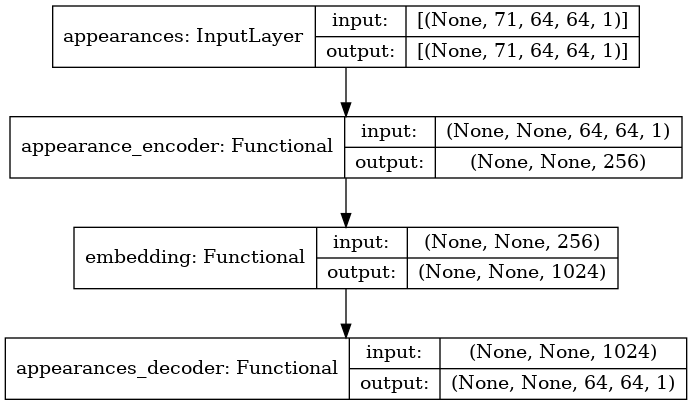

In [186]:
from tensorflow.keras.utils import plot_model
plot_model(TE.autoencoder, show_shapes=True)

In [187]:
def self_supervised_loss(y_true, y_pred):
    
    # Pair the current embedding with the future ground truth
    # so that we predict the future from the past
    
    current_reconstruction = y_pred
    gt = y_true
    
    loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    
    return loss

In [188]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

# Define optimizer
optimizer = RAdam(lr=1e-3, clipnorm=0.001)
losses = {'appearances_decoder': self_supervised_loss}
num_gpus = train_utils.count_gpus()
print('Training on {} GPUs'.format(num_gpus))

# Compile model
TE.autoencoder.compile(optimizer=optimizer, loss=losses)

# Train the model
model_path = '/data/models/app_pad_model'
steps_per_epoch = 2048
validation_steps = 100
n_epochs = 1

train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
]

loss_history = TE.autoencoder.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training on 1 GPUs
2048/2048 [==============================] - 716s 322ms/step - loss: 0.0075 - appearances_decoder_loss: 0.0075 - val_loss: 0.0050 - val_appearances_decoder_loss: 0.0050

Epoch 00001: val_loss improved from inf to 0.00505, saving model to /data/models/app_pad_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /data/models/app_pad_model/assets


INFO:tensorflow:Assets written to: /data/models/app_pad_model/assets


In [189]:
it = iter(train_data)

In [190]:
nxt = it.next()
inputs = nxt[0]['appearances']

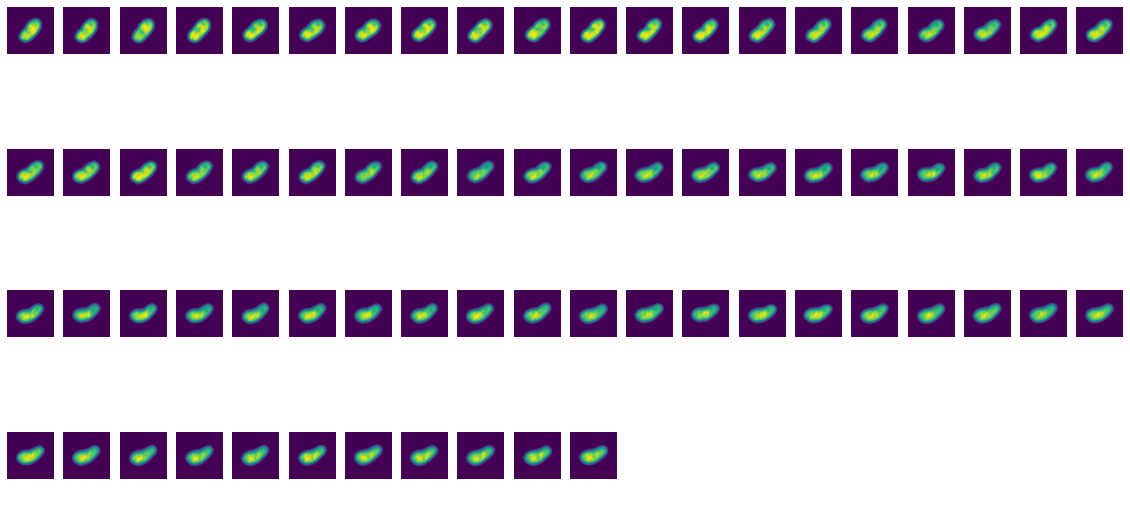

In [191]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
for j in range(71):
    axes.flatten()[j].imshow(inputs[0,j])
    axes.flatten()[j].set_axis_off()

In [192]:
app_encoded = TE.app_encoder(inputs)
embedding = TE.embedding_model(app_encoded)
reconstruction = TE.app_decoder(embedding)

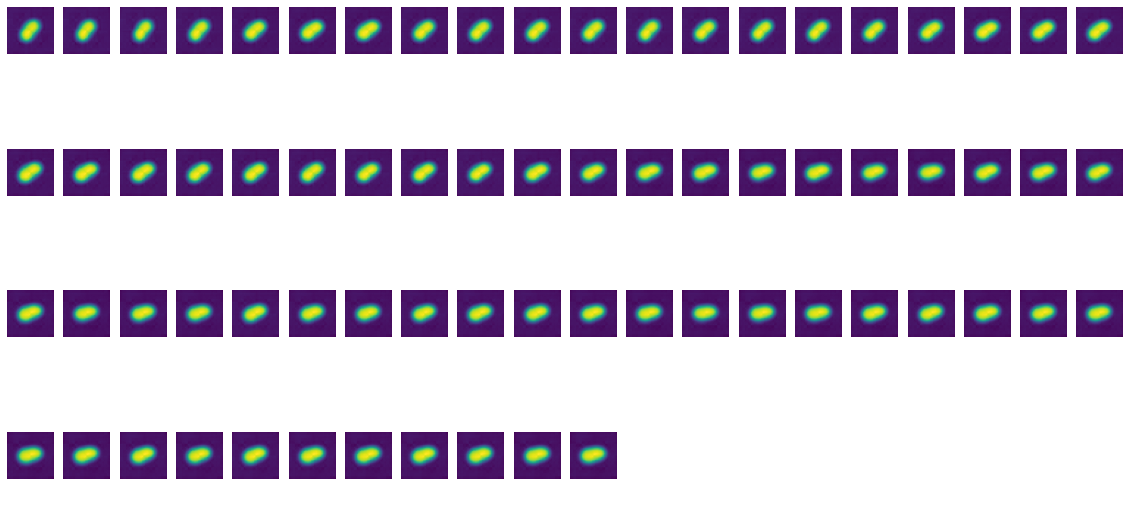

In [193]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
for j in range(71):
    axes.flatten()[j].imshow(reconstruction[0,j])
    axes.flatten()[j].set_axis_off()

In [194]:
import pandas as pd

def get_temp_embeddings_df():
    it = iter(train_data)

    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    num_cells = shape[0] * shape[2]

    temp_embeddings_lst = []

    for cell in range(num_cells):
        batch = cell // shape[2]
        pos = cell - shape[2] * (cell // shape[2])
        first_frame = 0
        last_frame = 0
        centroids_shape = track_info['centroids'].shape
        for frame in range(centroids_shape[1]):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                first_frame = frame
                break
        for frame in range(centroids_shape[1] - 1, -1, -1):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                last_frame = frame
                break
        
        nxt = it.next()
        inputs = nxt[0]['appearances']
        app_encoded = TE.app_encoder(inputs)
        embeddings = TE.embedding_model(app_encoded)
        for frame in range(first_frame, last_frame + 1):
            # append time number to embedding
            time = frame - first_frame
            temp_embeddings_lst.append(np.append(embeddings[0][frame].numpy().astype('float32'), time))
            
    cols = [idx for idx in range(TE.embedding_dim)]
    cols.append('Time')
    temp_embeddings_df = pd.DataFrame(temp_embeddings_lst, columns=cols)
    
    return temp_embeddings_df

from sklearn.preprocessing import StandardScaler

def standardize_embeddings():
    temp_embeddings_df = get_temp_embeddings_df()
    
    features = [idx for idx in range(TE.embedding_dim)]
    embeddings = temp_embeddings_df.loc[:, features].values
    std_embeddings = StandardScaler().fit_transform(embeddings)
    
    std_embeddings_df = pd.DataFrame(std_embeddings)
    
    return std_embeddings_df

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

def project_embeddings():
    std_embeddings_df = standardize_embeddings()
    
    principal_components = pca.fit_transform(std_embeddings_df)
    principal_df = pd.DataFrame(data = principal_components, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

temp_embeddings_df = get_temp_embeddings_df()
temp_embeddings_pca_df = project_embeddings()

import math

shape = track_info['appearances'].shape

"""
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()
    plt.savefig('pad_lstm_time_embeddings_sections/pad_lstm_time_embeddings_pca_' + str(time_init) + '_' + str(time_final) + '.jpg')
"""

"\nfor time_sect in range(10):\n    time_init = math.floor(shape[1] * time_sect / 10)\n    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1\n    fig = plt.figure(figsize = (8,8))\n    ax = fig.add_subplot(1,1,1) \n    ax.set_xlabel('Principal Component 1', fontsize = 15)\n    ax.set_ylabel('Principal Component 2', fontsize = 15)\n    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)\n    times = [time for time in range(time_init, time_final + 1)]\n    for time in times:\n        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)\n        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)\n    ax.grid()\n    plt.savefig('pad_lstm_time_embeddings_sections/pad_lstm_time_embeddings_pca_' + str(time_init) + '_' + str(time_final) + '.jpg')\n"

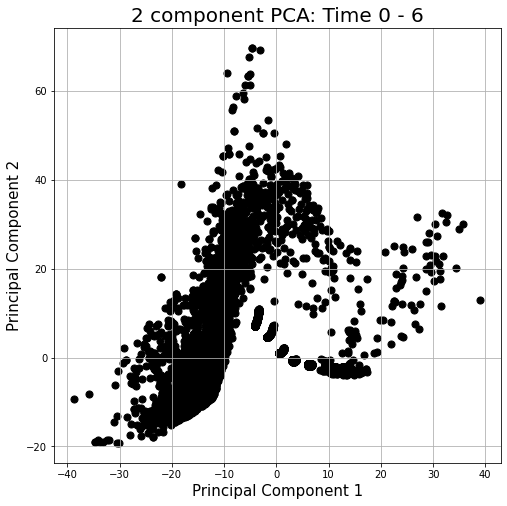

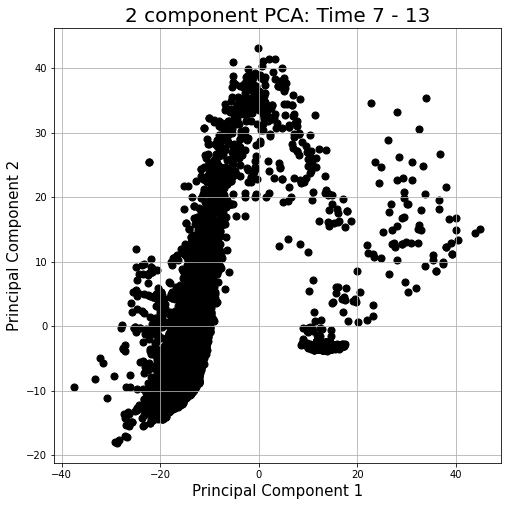

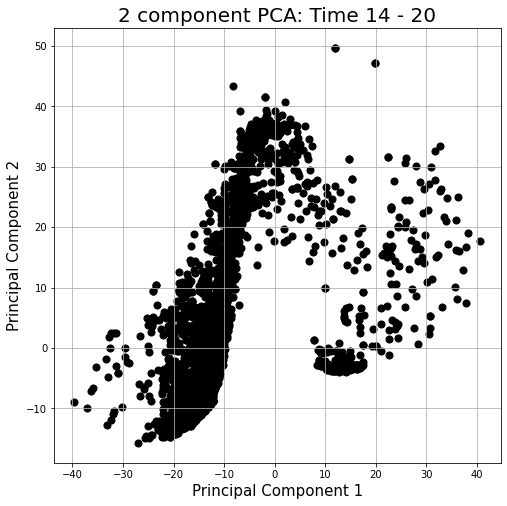

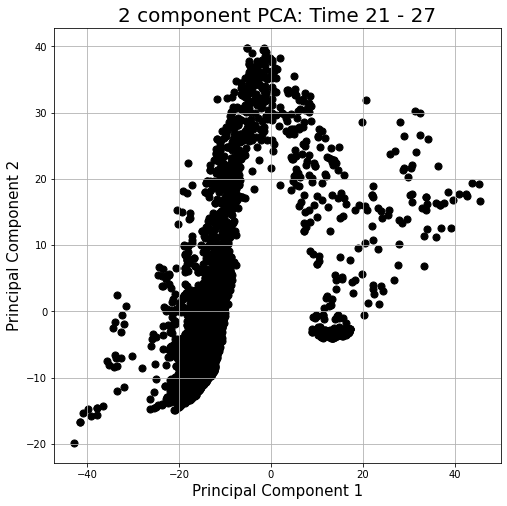

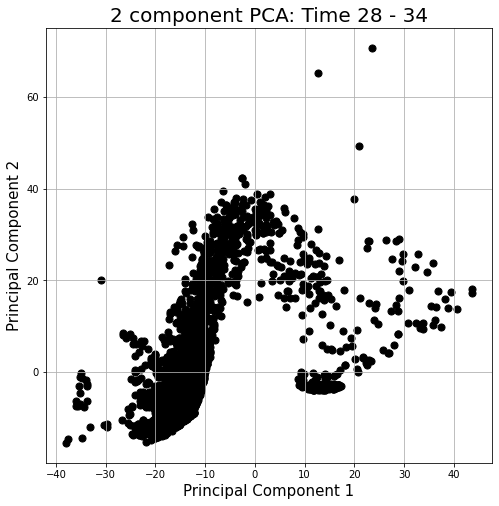

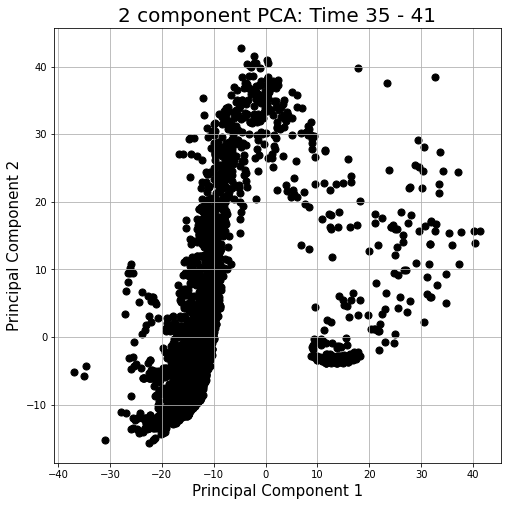

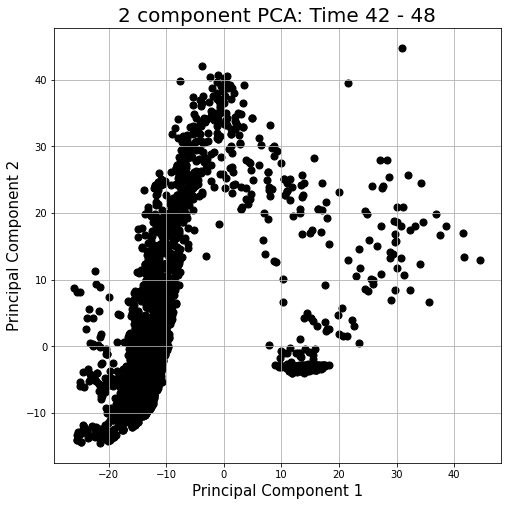

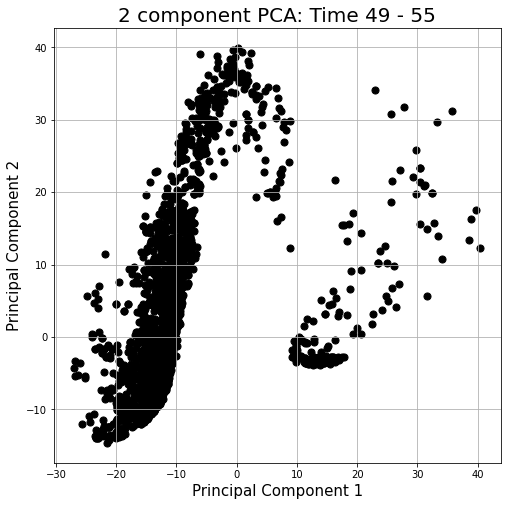

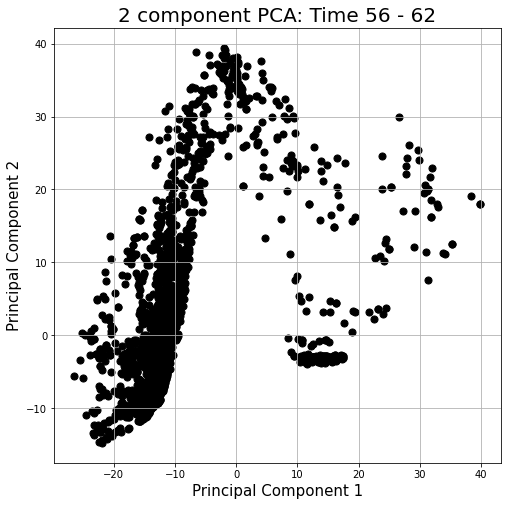

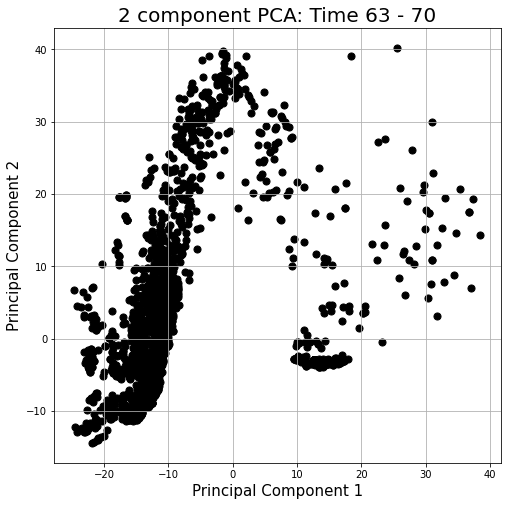

In [195]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()
    plt.savefig('pad_lstm_time_embeddings_sections/pad_lstm_time_embeddings_pca_' + str(time_init) + '_' + str(time_final) + '.jpg')

In [196]:
cols = [idx for idx in range(TE.embedding_dim)]
cols.append('Frame')
temp_embeddings_df.to_csv('/data/large_files/pad_lstm_temp_embeddings.csv', header=cols)

In [197]:
cols = ['component 1', 'component 2', 'Frame']
temp_embeddings_pca_df.to_csv('/data/large_files/pad_lstm_temp_embeddings_pca.csv', header=cols)

In [1]:
it = iter(train_data)

NameError: name 'train_data' is not defined